In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from timeit import default_timer
start = default_timer()
#plt.style.use('ggplot')

import scipy.sparse as sp
from scipy.sparse.linalg import svds
import itertools
from sklearn.metrics import confusion_matrix

import math
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils.fixes import signature
from sklearn.utils import shuffle
from sklearn.model_selection import KFold


In [2]:
from numba import autojit
from numba import jit

In [3]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):
    """
    Plots the long tail for a user-item interaction dataset.
    ----------
    df: pandas dataframe
        user-item interaction dataframe
        example:
    item_id_column: str
        column name identifying the item ids in the dataframe
    interaction_type: str
        type of user-item interactions
        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'
    percentage: float, default=None
        percent of volume to consider as the head (percent as a decimal)
        (if default=None no line will be plotted)
    x_tables bool, default=True
        if True, plot x-axis tick labels
        if False, no x-axis tick lavels will be plotted.
    Returns:
    -------
        A long tail plot
    """
    #calculate cumulative volumes
    volume_df = pd.DataFrame(df[item_id_column].value_counts())
    volume_df.reset_index(inplace=True)
    volume_df.columns = [item_id_column, "volume"]
    volume_df[item_id_column] = volume_df[item_id_column].astype(str)
    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()
    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()

    #line plot of cumulative volume
    x=range(0,len(volume_df))
    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")
    plt.xticks(x)

    #set labels
    ax.set_title('Long Tail Plot')
    ax.set_ylabel('# of ' + interaction_type)
    ax.set_xlabel(item_id_column)

    if percentage != None:
        #plot vertical line at the tail location
        head = volume_df[volume_df.percent_of_total_volume <= percentage]
        tail = volume_df[volume_df.percent_of_total_volume > percentage]
        items_in_head = len(head)
        items_in_tail = len(tail)
        plt.axvline(x=items_in_head, color="red",  linestyle='--')

        # fill area under plot
        head = head.append(tail.head(1))
        x1 = head.index.values
        y1 = head['volume']
        x2 = tail.index.values
        y2 = tail['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.2)
        ax.fill_between(x2, y2,  color="orange", alpha=0.2)

        #create legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),
                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]
        ax.legend(handles=legend_elements, loc=1)

    else:
        x1 = volume_df[item_id_column]
        y1 = volume_df['volume']
        ax.fill_between(x1, y1, color="blue", alpha=0.3)
    if x_labels == False:
        plt.xticks([], [])
        ax.set(xticklabels=[])
    else:
        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")

    plt.show()




In [4]:
movies = pd.read_csv('ml-20m/movies.csv')
ratings = pd.read_csv('ml-20m/ratings.csv')

In [5]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

In [6]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [7]:
no_genres_listed = movies[['movieId', '(no genres listed)']]
movies = movies.drop(columns=['(no genres listed)'])
genres_unique = genres_unique.drop(index=19)

In [8]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])

In [9]:
num_users = ratings.userId.unique().shape[0]
num_movies = ratings.movieId.unique().shape[0]
print(str(num_users) + ' Users')
print(str(num_movies) + ' Movies')
print('sparsity level is {}%'.format(round((1.0 - len(ratings)/float(num_users*num_movies))*100, 4)))

138493 Users
26744 Movies
sparsity level is 99.46%


In [10]:
def loadMovieNames():
    movieNames = {}
    for index, field in movies.iterrows():
        movieNames[int(field['movieId'])] = field['title']
    return movieNames
nameDict = loadMovieNames()

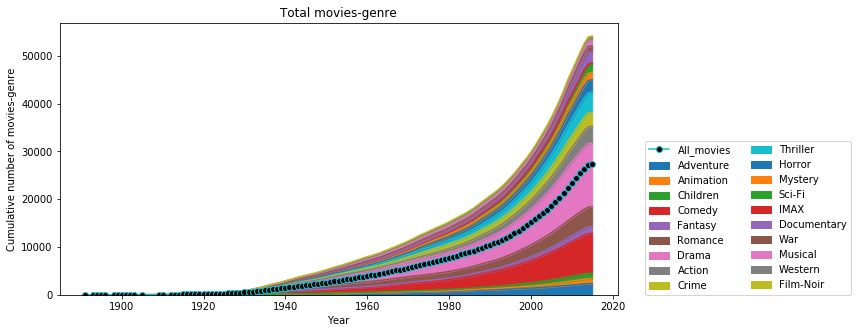

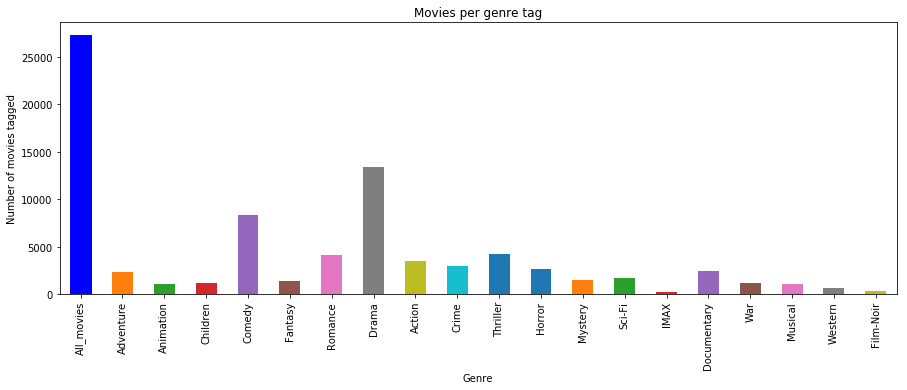

Elapsed time(sec):  1.39


In [11]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))


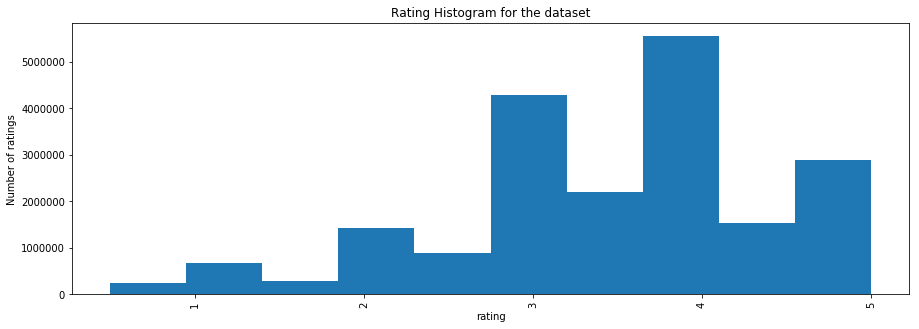

In [12]:
plt.figure(figsize=(15,5))
plt.hist(ratings['rating'])
#barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Rating Histogram for the dataset')
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.show()

### Popularity

In [19]:
overallpopularity = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
overallpopularity.index = overallpopularity.index.map(lambda x: nameDict[x])
overallpopularity.index.name = 'movie'
overallpopularity.head()

movie
Pulp Fiction (1994)                 67310
Forrest Gump (1994)                 66172
Shawshank Redemption, The (1994)    63366
Silence of the Lambs, The (1991)    63299
Jurassic Park (1993)                59715
Name: rating, dtype: int64

In [24]:
for genre in genres_unique.genre:
    m_id = movies[movies[genre]]['movieId']
    g_rating = ratings[ratings['movieId'].isin(m_id)]
    popularity = g_rating.groupby('movieId')['rating'].count().sort_values(ascending=False)
    popularity.index = popularity.index.map(lambda x: nameDict[x])
    popularity.index.name = 'movie'
    print("The top 10 most popular " + genre +  " movies are: ")
    i = 0
    for m, p in popularity.iteritems():
        if i == 10:
            break
        print(str(m) + '\t' + str(p) + ' people have rated this movie')
        i += 1
    print('\n')

The top 10 most popular Adventure movies are: 
Jurassic Park (1993)	59715 people have rated this movie
Star Wars: Episode IV - A New Hope (1977)	54502 people have rated this movie
Toy Story (1995)	49695 people have rated this movie
Apollo 13 (1995)	47777 people have rated this movie
Independence Day (a.k.a. ID4) (1996)	47048 people have rated this movie
Star Wars: Episode VI - Return of the Jedi (1983)	46839 people have rated this movie
Star Wars: Episode V - The Empire Strikes Back (1980)	45313 people have rated this movie
Dances with Wolves (1990)	44208 people have rated this movie
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)	43295 people have rated this movie
True Lies (1994)	43159 people have rated this movie


The top 10 most popular Animation movies are: 
Toy Story (1995)	49695 people have rated this movie
Aladdin (1992)	41842 people have rated this movie
Lion King, The (1994)	38991 people have rated this movie
Beauty and the Beast (1991)	35138 p

The top 10 most popular IMAX movies are: 
Apollo 13 (1995)	47777 people have rated this movie
Lion King, The (1994)	38991 people have rated this movie
Beauty and the Beast (1991)	35138 people have rated this movie
Dark Knight, The (2008)	20438 people have rated this movie
Batman Begins (2005)	18686 people have rated this movie
Matrix Reloaded, The (2003)	17003 people have rated this movie
Star Wars: Episode II - Attack of the Clones (2002)	16425 people have rated this movie
Spider-Man 2 (2004)	15712 people have rated this movie
V for Vendetta (2006)	14356 people have rated this movie
Inception (2010)	14023 people have rated this movie


The top 10 most popular Documentary movies are: 
Bowling for Columbine (2002)	12280 people have rated this movie
Hoop Dreams (1994)	10432 people have rated this movie
Super Size Me (2004)	8375 people have rated this movie
Fahrenheit 9/11 (2004)	8179 people have rated this movie
Roger & Me (1989)	7371 people have rated this movie
Crumb (1994)	5995 people

### Subset of the data

In [20]:
n=1000
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()
sub_ratings = ratings.query('userId in @users')
movies = sub_ratings.movieId.value_counts()
movies = movies[movies>n].index.tolist()
sub_ratings = sub_ratings.query('movieId in @movies')
cv_ratings = sub_ratings[['userId', 'movieId', 'rating']] # DataFrame for Cross-Validation

In [12]:
num_users = sub_ratings.userId.unique().shape[0]
num_movies = sub_ratings.movieId.unique().shape[0]
print(str(num_users) + ' Users')
print(str(num_movies) + ' Movies')
print('sparsity level is {}%'.format(round((1.0 - len(sub_ratings)/float(num_users*num_movies))*100, 4)))

1884 Users
553 Movies
sparsity level is 30.7304%


#### Subset for cold start problem

In [12]:
m=60
users = ratings.userId.value_counts()
users = users[users<m].index.tolist()[:1000]
cs_ratings = ratings.query('userId in @users')


In [515]:
df = pd.merge(ratings[['userId', 'movieId', 'rating']], movies[['movieId', 'year']], on='movieId')

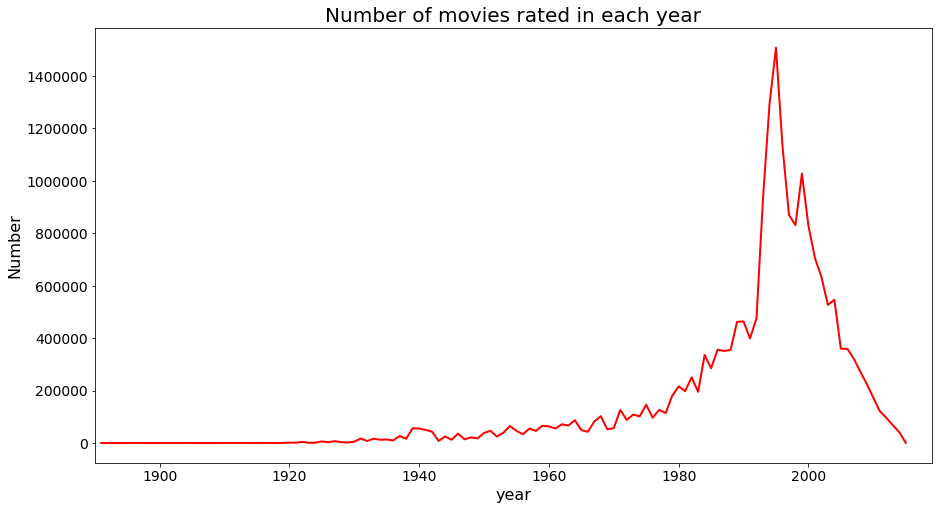

In [519]:
df.groupby('year').count()['movieId'].plot(figsize=(15,8),xlim=(1890,2019),fontsize=14,linewidth=2.0,c='r')
plt.ylabel('Number',fontsize=16)
plt.title("Number of movies rated in each year", fontsize=20)
plt.xlabel('year',fontsize=16)

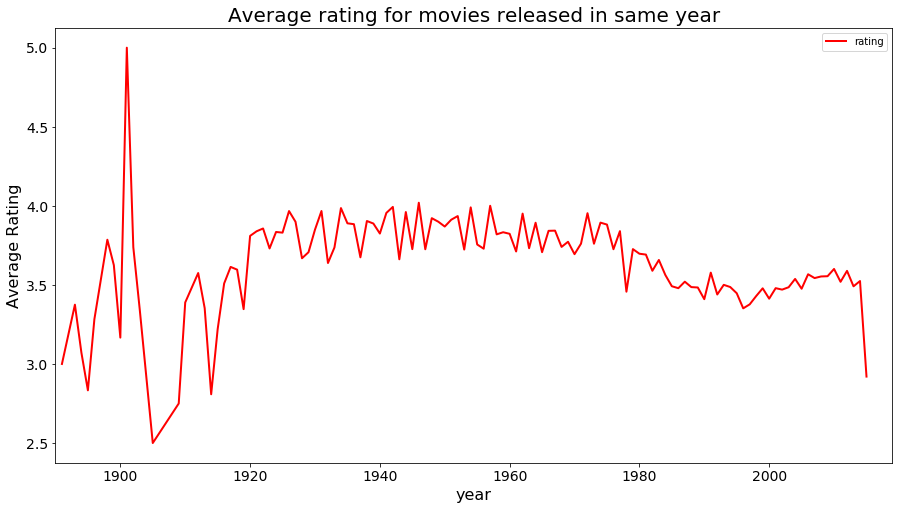

In [518]:
df[['rating', 'year']].groupby('year').mean().plot(figsize=(15,8),xlim=(1890,2019),fontsize=14,linewidth=2.0,c='r')
plt.ylabel('Average Rating', fontsize=16)
plt.title("Average rating for movies released in same year", fontsize=20)
plt.xlabel('year', fontsize=16)

### Popularity-based Model

In [13]:
popularity = sub_ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)
most_pop = popularity.index[:50]

In [14]:
cs_ratings.shape

(58896, 4)

In [15]:
R_origin = cs_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0).applymap(lambda x: 1 if x > 3 else 0)

In [16]:
def recall(movieid):
    like = R_origin[[movieid]][R_origin[movieid] == 1].index.tolist()
    correct = len(set(like).intersection(set(most_pop)))
    
    return correct / 20
def precision(movieid):
    like = R_origin[[movieid]][R_origin[movieid] == 1].index.tolist()
    correct = len(set(like).intersection(set(most_pop)))
    
    return correct / len(like)

In [17]:
tot_recall = 0
tot_precision = 0
for movieid in R_origin.columns:
    tot_recall += recall(movieid)
    tot_precision += precision(movieid)
tot_recall = tot_recall / (R_origin.shape[1] + 0.00001)
tot_precision = tot_precision / (R_origin.shape[1] + 0.00001)
print("Popularity for total recall rate is " + str(tot_recall))
print("Popularity for total precision rate is " + str(tot_precision))

Popularity for total recall rate is 0.3478999965209999
Popularity for total precision rate is 0.18755628368639413


In [18]:
kf = KFold(n_splits=10)

### Item-based CF

In [11]:
# Initializing 
#cur_rating = sub_ratings.sort_values(by=['movieId'])
# pivot ratings for item-based cf
item_embeddings = sub_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0)

item_ratings = sub_ratings.pivot(
    index='movieId',
    columns='userId',
    values='rating'
)

# pivot ratings for user-based cf
user_embeddings = sub_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
).fillna(0)

user_ratings = sub_ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)


In [88]:
class ItemCF(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, embeddings, rating_matrix):
        '''
        embeddings: item*user matrix
        rating_matrix: item*user matrix
        '''
        
        #self.ratings = ratings
     
        self.embeddings = embeddings
        self.rating_matrix = rating_matrix
        self.ids = self.embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        #sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()
    
    
    def rating_predict(self, seed_item, seed_user, k):
        similar_items = self.predict_similar_items(seed_item, k)
        mu = self.embeddings.mean().mean()
        bx = self.embeddings.loc[:, seed_user].mean() - mu
        bi = self.embeddings.loc[seed_item, :].mean() - mu
        num = sum([(similar_items['similarity_score'][str(i)] * (self.embeddings.loc[similar_items['item_id'][str(i)], seed_user] - bx - self.embeddings.loc[similar_items['item_id'][str(i)], :].mean() + mu)) for i in range(1, k)])
        den = sum(similar_items['similarity_score'].values())
        
        b_xi = mu + bx + bi
        
        return b_xi + num / (den + self.epsilon)
    
    #def rating_predict_matrix(self):
    #    rating = self.embeddings.values.T.dot(self.similarity_matrix.values)
    #    simsum = np.array([np.abs(self.similarity_matrix).sum(axis=1)])
    #    pred = pd.DataFrame(rating / (simsum + 0.001), columns=self.ids, index=self.embeddings.columns)
        
    #    return pred

In [13]:
class UserCF(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, embeddings, rating_matrix):
        '''
        embeddings: user*item matrix
        rating_matrix: user*item matrix
        '''
        self.embeddings = embeddings
        self.rating_matrix = rating_matrix
        self.ids = embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        #sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_users(self, seed_user, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_users = pd.DataFrame(self.similarity_matrix.loc[seed_user])
        similar_users.columns = ["similarity_score"]
        similar_users = similar_users.sort_values('similarity_score', ascending=False)
        similar_users = similar_users.head(n)
        similar_users.reset_index(inplace=True)
        similar_users = similar_users.rename(index=str, columns={"index": "user_id"})
        return similar_users.to_dict()
    
    def rating_predict(self, seed_user, seed_item, k):
        similar_users = self.predict_similar_users(seed_user, k)
        mu = self.embeddings.mean().mean()
        bi = self.embeddings.loc[:, seed_item].mean() - mu
        bx = self.embeddings.loc[seed_user, :].mean() - mu
        num = sum([(similar_users['similarity_score'][str(i)] * (self.embeddings.loc[similar_users['user_id'][str(i)], seed_item] - bi - self.embeddings.loc[similar_users['user_id'][str(i)], :].mean() + mu)) for i in range(1, k)])
        den = sum(similar_users['similarity_score'].values())
        
        b_xi = mu + bx + bi
        
        return b_xi + num / (den + self.epsilon)
    
   # def rating_predict_matrix(self):
   #     rating = self.embeddings.values.T.dot(self.similarity_matrix.values)
   #     simsum = np.array([np.abs(self.similarity_matrix).sum(axis=1)])
   #     pred = pd.DataFrame(rating / (simsum + 0.001), columns=self.ids, index=self.embeddings.columns)
        
   #     return pred

In [14]:
def rmse(pred, actual):
    return math.sqrt(mean_squared_error(pred, actual))

#### Test set for CF

In [24]:
cv_ratings = shuffle(sub_ratings[['movieId', 'userId', 'rating']])

In [31]:
test = item_embeddings.sample(frac=0.2, replace=False)
movieid = test.index.tolist()
test = test.sample(frac=0.2, replace=False, axis=1)
userid = test.columns.tolist()
test_ratings = sub_ratings[['movieId', 'userId', 'rating']][sub_ratings['userId'].isin(userid)]
test_ratings = test_ratings[test_ratings['movieId'].isin(movieid)]

In [283]:
testset = sub_ratings[['userId', 'movieId', 'rating']].sample(frac=0.2, replace=False, random_state=1)
trainset = sub_ratings[['userId', 'movieId', 'rating']][~sub_ratings[['userId', 'movieId', 'rating']].index.isin(testset.index)]

In [25]:
userid = cv_ratings['userId'].unique().tolist()
movieid = cv_ratings['movieId'].unique().tolist()

#### Item-based CF

In [ ]:

RMSE = 0
for i in range(3):
    m = int(len(userid) * (i + 1) / 3)
    for j in range(3):
        k = int(len(movieid) * (j + 1) / 3)
        test_userid = userid[i : m]
        test_movieid = movieid[j : k]
        test_ratings = cv_ratings[cv_ratings['userId'].isin(test_userid)]
        test_ratings = test_ratings[test_ratings['movieId'].isin(test_movieid)]
        iembeddings = item_embeddings
        iembeddings.loc[test_movieid, test_userid] = iembeddings.loc[test_movieid, test_userid].applymap(lambda x: 0)
        itemcf = ItemCF(iembeddings, item_ratings)
        itemcf.calculate_cosine_similarity_matrix()
        test_ratings['item_pred'] = test_ratings.apply(lambda x: itemcf.rating_predict(x['movieId'], x['userId'], 15), axis=1)
        err = rmse(test_ratings['item_pred'], test_ratings['rating'])
        print(str(i) + "th fold cross validation rmse result: " + str(err))
        RMSE += err
RMSE = RMSE / 10
print("RMSE for 10-fold CV is " + str(RMSE))



#### User-based CF

In [88]:
uembeddings = user_embeddings
uembeddings.loc[userid, movieid] = uembeddings.loc[userid, movieid].applymap(lambda x: 0)
usercf = UserCF(uembeddings, user_ratings)
usercf.calculate_cosine_similarity_matrix()
test_ratings['user_pred'] = test_ratings.apply(lambda x: usercf.rating_predict(x['userId'], x['movieId'], 15), axis=1)
rmse(test_ratings['user_pred'], test_ratings['rating'])

Finish calculating similarity matrix


1.1202641686009098

In [ ]:
RMSE = 0
for i in range(3):
    m = int(len(userid) * (i + 1) / 3)
    for j in range(3):
        k = int(len(movieid) * (j + 1) / 3)
        test_userid = userid[i : m]
        test_movieid = movieid[j : k]
        test_ratings = cv_ratings[cv_ratings['userId'].isin(test_userid)]
        test_ratings = test_ratings[test_ratings['movieId'].isin(test_movieid)]
        uembeddings = user_embeddings
        uembeddings.loc[test_userid, test_movieid] = uembeddings.loc[test_userid, test_movieid].applymap(lambda x: 0)
        usercf = UserCF(uembeddings, user_ratings)
        usercf.calculate_cosine_similarity_matrix()
        test_ratings['user_pred'] = test_ratings.apply(lambda x: usercf.rating_predict(x['userId'], x['movieId'], 15), axis=1)
        err = rmse(test_ratings['user_pred'], test_ratings['rating'])
        print(str(i) + "th fold cross validation rmse result: " + str(err))
        RMSE += err
RMSE = RMSE / 10
print("RMSE for 10-fold CV is " + str(RMSE))

### Excluding Bias

In [288]:
class ItemCFwoBias(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, ratings):
        '''
        embeddings: item*user matrix
        rating_matrix: item*user matrix
        '''
        
        self.ratings = ratings
        self.embeddings = self.ratings.pivot(
                                index='movieId',
                                columns='userId',
                                values='rating'
                                            ).fillna(0)

        self.rating_matrix = self.ratings.pivot(
                            index='movieId',
                            columns='userId',
                            values='rating'
                                            )
        #self.embeddings = embeddings
        #self.rating_matrix = rating_matrix
        self.ids = self.embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        #sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        sub_rowmean = self.embeddings
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_items(self, seed_item, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_items = pd.DataFrame(self.similarity_matrix.loc[seed_item])
        similar_items.columns = ["similarity_score"]
        similar_items = similar_items.sort_values('similarity_score', ascending=False)
        similar_items = similar_items.head(n)
        similar_items.reset_index(inplace=True)
        similar_items = similar_items.rename(index=str, columns={"index": "item_id"})
        return similar_items.to_dict()
    
    def rating_predict(self, seed_item, seed_user, k):
        self.k = k
        similar_items = self.predict_similar_items(seed_item, k)
        #mu = self.embeddings.mean().mean()
        #bx = self.embeddings.loc[:, seed_user].mean() - mu
        #bi = self.embeddings.loc[seed_item, :].mean() - mu
        num = sum([(similar_items['similarity_score'][str(i)] * self.embeddings.loc[similar_items['item_id'][str(i)], seed_user]) for i in range(1, k)])
        den = sum(similar_items['similarity_score'].values())
        
        #b_xi = mu + bx + bi
        #return b_xi + num / (den + self.epsilon)
        return num / (den + self.epsilon)
    def recommend(self, user, k):
        '''Recommend top k movies that user might like most'''
        
        item = ratings['movieId'].drop_duplicates()
        item['pred'] = item['movieId'].apply(lambda x: self.rating_predict(x['movieId'], user, self.k), axis=1)
        item.sort_values(by='pred', ascending=False, inplace=True)
        topid = item['movieId'][:k].values.flatten().tolist()
        return list(map(lambda x: nameDict[x], topid))
        
        
        
        

In [289]:
itemcfwobias = ItemCFwoBias(trainset)
itemcfwobias.calculate_cosine_similarity_matrix()

Finish calculating similarity matrix


In [290]:
ibtest_ratings = testset
ibtest_ratings['item_pred'] = ibtest_ratings.apply(lambda x: itemcfwobias.rating_predict(x['movieId'], x['userId'], 15), axis=1)
rmse(ibtest_ratings['item_pred'], ibtest_ratings['rating'])

1.3256999461146088

In [291]:
class UserCFwoBias(object):
    '''This class calculates a similarity matrix from latent embeddings.
    Input: embeddings - a pandas dataframe of items and latent dimensions.
    '''

    def __init__(self, ratings):
        '''
        embeddings: user*item matrix
        rating_matrix: user*item matrix
        '''
        self.ratings = ratings
        self.embeddings = ratings.pivot(
                                index='userId',
                                columns='movieId',
                                values='rating'
                                            ).fillna(0)

        self.rating_matrix = ratings.pivot(
                            index='userId',
                            columns='movieId',
                            values='rating'
                                            )
        #self.embeddings = embeddings
        #self.rating_matrix = rating_matrix
        self.ids = self.embeddings.index.tolist()
        self.epsilon = 0.001

    def calculate_cosine_similarity_matrix(self):
        '''Calculates a cosine similarity matrix from the embeddings'''
        #sub_rowmean = self.rating_matrix.sub(self.rating_matrix.mean(axis=1), axis=0).fillna(0)
        sub_rowmean = self.embeddings.fillna(0)
        self.similarity_matrix = pd.DataFrame(cosine_similarity(
            X=sub_rowmean),
            index=self.ids)
        self.similarity_matrix.columns = self.ids
        #return self.similarity_matrix
        print('Finish calculating similarity matrix')

    def predict_similar_users(self, seed_user, n):
        '''Use the similarity_matrix to return n most similar items.'''
        similar_users = pd.DataFrame(self.similarity_matrix.loc[seed_user])
        similar_users.columns = ["similarity_score"]
        similar_users = similar_users.sort_values('similarity_score', ascending=False)
        similar_users = similar_users.head(n)
        similar_users.reset_index(inplace=True)
        similar_users = similar_users.rename(index=str, columns={"index": "user_id"})
        return similar_users.to_dict()
    
    def rating_predict(self, seed_user, seed_item, k):
        similar_users = self.predict_similar_users(seed_user, k)
        #mu = self.embeddings.mean().mean()
        #bi = self.embeddings.loc[:, seed_item].mean() - mu
        #bx = self.embeddings.loc[seed_user, :].mean() - mu
        num = sum([(similar_users['similarity_score'][str(i)] * self.embeddings.loc[similar_users['user_id'][str(i)], seed_item]) for i in range(1, k)])
        den = sum(similar_users['similarity_score'].values())
        
        #b_xi = mu + bx + bi
        #return b_xi + num / (den + self.epsilon)
        
        return num / (den + self.epsilon)

In [292]:
usercfwobias = UserCFwoBias(trainset)
usercfwobias.calculate_cosine_similarity_matrix()
ubtest_ratings = testset
ubtest_ratings['user_pred'] = ubtest_ratings.apply(lambda x: usercfwobias.rating_predict(x['userId'], x['movieId'], 15), axis=1)
rmse(ubtest_ratings['user_pred'], ubtest_ratings['rating'])



Finish calculating similarity matrix


1.5044588803546677

In [ ]:
RMSE = 0
for train, test in kf.split(cv_ratings):
    train_ratings = cv_ratings.iloc[train, :]
    test_ratings = cv_ratings.iloc[test, :]
        #iembeddings = item_embeddings
        #iembeddings.loc[test_movieid, test_userid] = iembeddings.loc[test_movieid, test_userid].applymap(lambda x: 0)
    itemcf = ItemCFwoBias(train_ratings)
    itemcf.calculate_cosine_similarity_matrix()
    test_ratings['item_pred'] = test_ratings.apply(lambda x: itemcf.rating_predict(x['movieId'], x['userId'], 15), axis=1)
    err = rmse(test_ratings['item_pred'], test_ratings['rating'])
    print(str(i) + "th fold cross validation rmse result: " + str(err))
    RMSE += err
RMSE = RMSE / 10
print("RMSE for 10-fold CV is " + str(RMSE))

In [ ]:
RMSE = 0
for train, test in kf.split(cv_ratings):
    train_ratings = cv_ratings.iloc[train, :]
    test_ratings = cv_ratings.iloc[test, :]
        #iembeddings = item_embeddings
        #iembeddings.loc[test_movieid, test_userid] = iembeddings.loc[test_movieid, test_userid].applymap(lambda x: 0)
    usercf = UserCFwoBias(train_ratings)
    usercf.calculate_cosine_similarity_matrix()
    test_ratings['user_pred'] = test_ratings.apply(lambda x: usercf.rating_predict(x['userId'], x['movieId'], 15), axis=1)
    err = rmse(test_ratings['item_pred'], test_ratings['rating'])
    print(str(i) + "th fold cross validation rmse result: " + str(err))
    RMSE += err
RMSE = RMSE / 10
print("RMSE for 10-fold CV is " + str(RMSE))

#### SVD

In [13]:
def matrix_rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return math.sqrt(mean_squared_error(prediction, ground_truth))

In [14]:
testset = sub_ratings[['userId', 'movieId', 'rating']].sample(frac=0.2, replace=False, random_state=1)
trainset = sub_ratings[['userId', 'movieId', 'rating']][~sub_ratings[['userId', 'movieId', 'rating']].index.isin(testset.index)]
#valset = trainset.sample(frac=0.25, replace=False, random_state=1)
#trainset = trainset[~trainset.index.isin(valset.index)]

In [15]:
print(testset.shape)
#print(valset.shape)
print(trainset.shape)
print(sub_ratings.shape)

(144337, 3)
(577350, 3)
(721687, 4)


#### 10-fold CV

In [21]:
RMSE = 0
i = 1
for train, test in kf.split(cv_ratings):
    trainset = cv_ratings.iloc[train, :]
    testset = cv_ratings.iloc[test, :]
    
    train_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
    #val_matrix = valset.pivot(index='userId', columns='movieId', values='rating')
    test_matrix = testset.pivot(index='userId', columns='movieId', values='rating')
    
    u, s, vt = svds(train_matrix.fillna(0).values, k = 10)#tweak k, dimensionality for rank matrix
    s_diag_matrix=np.diag(s)
    X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
    err = matrix_rmse(X_pred, test_matrix.fillna(0).values)
    print(str(i) + 'th fold cross validation rmse is ' + str(err))
    RMSE += err
RMSE /= 10
print ('matrix-factorization SVD RMSE: %.2f' %RMSE)

    
    

1th fold cross validation rmse is 1.762804364106825
1th fold cross validation rmse is 1.7385130883273945
1th fold cross validation rmse is 1.6948705215594755
1th fold cross validation rmse is 1.7405361378185464
1th fold cross validation rmse is 1.7221107641042304
1th fold cross validation rmse is 1.7011236280288333
1th fold cross validation rmse is 1.7172597736943394
1th fold cross validation rmse is 1.7231076149732774
1th fold cross validation rmse is 1.721340556691173
1th fold cross validation rmse is 1.7074719494915875
matrix-factorization SVD RMSE: 1.72


In [11]:
train_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
#val_matrix = valset.pivot(index='userId', columns='movieId', values='rating')
test_matrix = testset.pivot(index='userId', columns='movieId', values='rating')

In [37]:
%time u, s, vt = svds(train_matrix.fillna(0).values, k = 10)#tweak k, dimensionality for rank matrix
%time s_diag_matrix=np.diag(s)
%time X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

CPU times: user 528 ms, sys: 81.8 ms, total: 610 ms
Wall time: 659 ms
CPU times: user 104 µs, sys: 16 µs, total: 120 µs
Wall time: 43.2 µs
CPU times: user 13.4 ms, sys: 908 µs, total: 14.3 ms
Wall time: 4.86 ms


In [38]:
print ('matrix-factorization SVD RMSE: %.2f' %matrix_rmse(X_pred, test_matrix.fillna(0).values))


matrix-factorization SVD RMSE: 1.58


#### Matrix Factorization with SGD

In [95]:
# R = QP.T
def prediction(Q,P):
    return Q.dot(P.T)

In [12]:
class LFM(object):
    ''' This class built a recommender system based on latent factor model with 
    stochastic gradient descent'''
    
    def __init__(self, train, test):
        self.ids = train.index
        self.columns = train.columns
        self.R = train.fillna(0).values
        self.T = test.fillna(0).values
        self.Q = None
        self.P = None
    
    def initialize(self, Q=None, P=None, k=1):
        '''initialize Q, P and latent factor k. The default values for Q and P
        are the results for SVD for R'''
        if (Q is not None) and (P is not None):
            self.Q = Q
            self.P = P
        else:
            u, s, vt = svds(self.R, k=k)
            s_diag=np.diag(s)
            self.Q = u
            self.P = s_diag.dot(vt).T
            
    def rmse_(self, R, Q, P):
       # prediction = Q.dot(P.T)
       # prediction = prediction[R.nonzero()].flatten() 
       # true_value = R[R.nonzero()].flatten()
       # return math.sqrt(mean_squared_error(prediction, true_value))
        I = R != 0  # Indicator function which is zero for missing data
        ME = I * (R - np.dot(Q, P.T))  # Errors between real and predicted ratings
        MSE = ME**2  
        return np.sqrt(np.sum(MSE)/np.sum(I))
    @autojit
    def train(self, lr1, lr2, reg1, reg2, maxiter):
        '''SGD for training
        @lr1: learning rate for Q   @lr2: learning rate for P
        @reg1: regularizer for Q    @reg2: regularizer for P
        @maxiter: stop when epochs exceed this value
        '''
        
        train_errors = []
        test_errors = []
        users,items = self.R.nonzero() 
        for epoch in range(maxiter):
            dR = 2 * (self.R - self.Q.dot(self.P.T))
            start_time = default_timer()
            for u, i in zip(users, items):
                dq = dR[u, i] * self.P[i, :] - 2 * reg2 * self.Q[u, :]
                self.Q[u, :] += lr1 * dq
                dp = dR[u, i] * self.Q[u, :] - 2 * reg1 * self.P[i, :]
                self.P[i, :] += lr2 * dp
            
            trg_err = self.rmse_(self.R, self.Q, self.P)
            print("current training error: " + str(trg_err))
            train_errors = train_errors + [trg_err]
            test_err = self.rmse_(self.T, self.Q, self.P)
            print("current test error: " + str(test_err))
            test_errors = test_errors + [test_err]
            print("Run took %.2f seconds for epoch " % (default_timer() - start_time) + str(epoch))
        self.train_errors = train_errors
        self.test_errors = test_errors
        return self.train_errors[-1], self.test_errors[-1]
            
    def trainplot(self):
        
        # Check performance by plotting train and test errors
        fig, ax = plt.subplots()
        ax.plot(self.train_errors, color="b", label='Training RMSE')
        ax.plot(self.test_errors, color="r", label='Test RMSE')
        ax.set_title("Error During Stochastic GD")
        ax.set_xlabel("Number of Epochs")
        ax.set_ylabel("RMSE")
        ax.legend()
    def pred_forall(self):
        self.pred = pd.DataFrame(self.Q.dot(self.P.T), index=self.ids, columns=self.columns)

        
    def recommend(self, userid, k):
        '''Input userid to recommend top k movies that this user might like most'''
        
        rec = list(self.pred.loc[userid, :].argsort()[-k:][::-1].index)
        
        return list(map(lambda x: nameDict[x], rec))
            

In [103]:
k_option = [5, 10, 20, 50, 80, 100, 120, 150, 170, 200]
train_errors = []
test_errors = []
lfm = LFM(train_matrix, test_matrix)
for k in k_option:
    lfm.initialize(k=k)
    lr = 0.0000001
    reg = 0.5
    trg_err, test_err = lfm.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]
    

current training error: 1.14821396836516
current test error: 1.183715044794273
Run took 11.14 seconds for epoch 0
current training error: 1.0204026975905764
current test error: 1.0490891069932684
Run took 11.09 seconds for epoch 1
current training error: 0.9820924440029912
current test error: 1.0064898296975469
Run took 10.95 seconds for epoch 2
current training error: 0.9694808389693654
current test error: 0.9915990775302888
Run took 10.91 seconds for epoch 3
current training error: 0.9645376139259075
current test error: 0.9854919089223565
Run took 10.87 seconds for epoch 4
current training error: 0.9620871941689102
current test error: 0.982447608948418
Run took 10.86 seconds for epoch 5
current training error: 0.9605362914342016
current test error: 0.9805918637576934
Run took 10.87 seconds for epoch 6
current training error: 0.9593502106014743
current test error: 0.979249614092367
Run took 10.85 seconds for epoch 7
current training error: 0.9583325026271201
current test error: 0.9781

current training error: 0.9717173529535666
current test error: 1.6543237939466429
Run took 12.75 seconds for epoch 10
current training error: 0.9705540826579278
current test error: 1.6528027857692207
Run took 12.92 seconds for epoch 11
current training error: 0.969404899657783
current test error: 1.6513911334179179
Run took 12.98 seconds for epoch 12
current training error: 0.9682679266581604
current test error: 1.6500471735667805
Run took 12.73 seconds for epoch 13
current training error: 0.967141986991317
current test error: 1.6487467882682334
Run took 14.04 seconds for epoch 14
current training error: 0.966026290155572
current test error: 1.6474756820313372
Run took 16.97 seconds for epoch 15
current training error: 0.9649202706862827
current test error: 1.6462251781901325
Run took 17.32 seconds for epoch 16
current training error: 0.9638235008491067
current test error: 1.6449898832564307
Run took 13.42 seconds for epoch 17
current training error: 0.9627356409220285
current test err

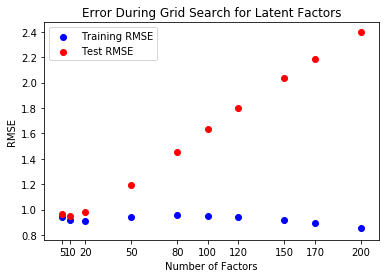

In [127]:
fig, ax = plt.subplots()
ax.scatter(k_option, train_errors, color="b", label='Training RMSE')
ax.scatter(k_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Latent Factors")
ax.set_xlabel("Number of Factors")
ax.set_ylabel("RMSE")
ax.set_xticks([5, 10, 20, 50, 80, 100, 120, 150, 170, 200])
ax.legend()

In [128]:
reg_option = [0.001, 0.01, 0.05, 0.2, 0.5, 1, 1.5]
train_errors = []
test_errors = []
lfm = LFM(train_matrix, test_matrix)
for reg in reg_option:
    lfm.initialize(k=15)
    lr = 0.0000001
    trg_err, test_err = lfm.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]
    

current training error: 1.096846365917348
current test error: 1.1996204304109799
Run took 12.32 seconds for epoch 0
current training error: 0.9877536522901001
current test error: 1.06783521402165
Run took 12.30 seconds for epoch 1
current training error: 0.9554294068071754
current test error: 1.0215911355975518
Run took 11.10 seconds for epoch 2
current training error: 0.9445485082101484
current test error: 1.0032455948686096
Run took 11.03 seconds for epoch 3
current training error: 0.9399541575420538
current test error: 0.9947703727179311
Run took 10.89 seconds for epoch 4
current training error: 0.9373794013722951
current test error: 0.9901747031590328
Run took 10.90 seconds for epoch 5
current training error: 0.935528310280352
current test error: 0.9872614479796743
Run took 10.91 seconds for epoch 6
current training error: 0.9339702213259065
current test error: 0.9851415680444106
Run took 10.90 seconds for epoch 7
current training error: 0.9325479555736882
current test error: 0.983

current training error: 0.9298425954625188
current test error: 0.9805026632984112
Run took 10.92 seconds for epoch 10
current training error: 0.9285656565727114
current test error: 0.9791995012263747
Run took 11.04 seconds for epoch 11
current training error: 0.9273136396746768
current test error: 0.9779473933455058
Run took 11.32 seconds for epoch 12
current training error: 0.9260825892409275
current test error: 0.9767315345367111
Run took 11.72 seconds for epoch 13
current training error: 0.9248700920134872
current test error: 0.9755432553600377
Run took 11.06 seconds for epoch 14
current training error: 0.9236745707782243
current test error: 0.9743772939369193
Run took 11.01 seconds for epoch 15
current training error: 0.9224949273988169
current test error: 0.9732303363622637
Run took 11.01 seconds for epoch 16
current training error: 0.9213303520983496
current test error: 0.9721002131199423
Run took 11.09 seconds for epoch 17
current training error: 0.9201802163620577
current test 

current training error: 0.9170782181255238
current test error: 0.9679629340624529
Run took 11.10 seconds for epoch 20
current training error: 0.9159346419884277
current test error: 0.9668497271530523
Run took 11.02 seconds for epoch 21
current training error: 0.9148043403326986
current test error: 0.9657494324374337
Run took 11.09 seconds for epoch 22
current training error: 0.9136869975179078
current test error: 0.9646616321509732
Run took 11.12 seconds for epoch 23
current training error: 0.9125823212373408
current test error: 0.963585966015787
Run took 11.11 seconds for epoch 24
current training error: 0.9114900374582317
current test error: 0.9625221152742739
Run took 11.03 seconds for epoch 25
current training error: 0.9104098868563838
current test error: 0.9614697919663756
Run took 11.28 seconds for epoch 26
current training error: 0.9093416222635516
current test error: 0.9604287315938875
Run took 11.03 seconds for epoch 27
current training error: 0.908285006811703
current test er

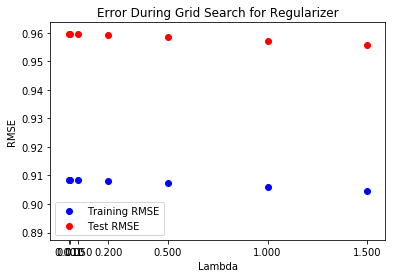

In [132]:
fig, ax = plt.subplots()
ax.scatter(reg_option, train_errors, color="b", label='Training RMSE')
ax.scatter(reg_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Regularizer")
ax.set_xlabel("Lambda")
ax.set_ylabel("RMSE")
ax.set_xticks([0.001, 0.01, 0.05, 0.2, 0.5, 1, 1.5])
ax.legend()

current training error: 1.1075563579338032
current test error: 1.189835204108745
Run took 16.16 seconds for epoch 0
current training error: 0.9948906974412526
current test error: 1.058966335483747
Run took 15.71 seconds for epoch 1
current training error: 0.9611322038084129
current test error: 1.0140513650449887
Run took 15.58 seconds for epoch 2
current training error: 0.9495965066684595
current test error: 0.9965457474531153
Run took 15.82 seconds for epoch 3
current training error: 0.9446408730302853
current test error: 0.9884883484488909
Run took 15.23 seconds for epoch 4
current training error: 0.9418253309798759
current test error: 0.9840543663097401
Run took 14.89 seconds for epoch 5
current training error: 0.9397879257315468
current test error: 0.9811613585651547
Run took 15.64 seconds for epoch 6
current training error: 0.9380706516864997
current test error: 0.9789861711704418
Run took 14.08 seconds for epoch 7
current training error: 0.9365041203732853
current test error: 0.9

current training error: 0.8738614644536096
current test error: 0.9147796054092565
Run took 14.25 seconds for epoch 70
current training error: 0.8731373304305977
current test error: 0.9140545138966449
Run took 14.95 seconds for epoch 71
current training error: 0.872419363160638
current test error: 0.9133353768122282
Run took 15.07 seconds for epoch 72
current training error: 0.8717074759330151
current test error: 0.9126221123150421
Run took 14.76 seconds for epoch 73
current training error: 0.8710015838572043
current test error: 0.9119146402546655
Run took 15.54 seconds for epoch 74
current training error: 0.8703016038147479
current test error: 0.9112128821269746
Run took 14.08 seconds for epoch 75
current training error: 0.869607454412547
current test error: 0.9105167610312077
Run took 13.11 seconds for epoch 76
current training error: 0.8689190559375396
current test error: 0.9098262016283114
Run took 13.08 seconds for epoch 77
current training error: 0.8682363303127093
current test er

current training error: 0.8345489651058665
current test error: 0.8750700665178264
Run took 12.99 seconds for epoch 140
current training error: 0.8341153578400813
current test error: 0.8746278021849975
Run took 13.10 seconds for epoch 141
current training error: 0.8336845188281891
current test error: 0.8741882580448587
Run took 13.13 seconds for epoch 142
current training error: 0.8332564223129845
current test error: 0.8737514093319471
Run took 13.05 seconds for epoch 143
current training error: 0.8328310428906347
current test error: 0.8733172316160982
Run took 12.99 seconds for epoch 144
current training error: 0.8324083555037738
current test error: 0.8728857007959678
Run took 13.06 seconds for epoch 145
current training error: 0.8319883354347681
current test error: 0.8724567930927134
Run took 12.96 seconds for epoch 146
current training error: 0.8315709582991462
current test error: 0.8720304850438226
Run took 13.18 seconds for epoch 147
current training error: 0.8311562000391889
curre

current training error: 0.8097299785917453
current test error: 0.8495706391882886
Run took 13.04 seconds for epoch 210
current training error: 0.8094425294685177
current test error: 0.8492728544974736
Run took 13.16 seconds for epoch 211
current training error: 0.8091566338489901
current test error: 0.8489766164581782
Run took 13.38 seconds for epoch 212
current training error: 0.8088722802631053
current test error: 0.8486819139249445
Run took 13.10 seconds for epoch 213
current training error: 0.8085894573523643
current test error: 0.8483887358591878
Run took 13.10 seconds for epoch 214
current training error: 0.8083081538683247
current test error: 0.8480970713277646
Run took 13.07 seconds for epoch 215
current training error: 0.8080283586711267
current test error: 0.8478069095015697
Run took 12.95 seconds for epoch 216
current training error: 0.8077500607280461
current test error: 0.8475182396541574
Run took 13.07 seconds for epoch 217
current training error: 0.8074732491120745
curre

current training error: 0.7930218546486516
current test error: 0.8321469024521365
Run took 13.06 seconds for epoch 279
current training error: 0.7928194842610333
current test error: 0.8319342886095951
Run took 13.03 seconds for epoch 280
current training error: 0.792618077302347
current test error: 0.831722645553069
Run took 12.98 seconds for epoch 281
current training error: 0.7924176275178954
current test error: 0.8315119671439786
Run took 12.98 seconds for epoch 282
current training error: 0.792218128702849
current test error: 0.8313022472917626
Run took 13.13 seconds for epoch 283
current training error: 0.7920195747017489
current test error: 0.8310934799533986
Run took 13.09 seconds for epoch 284
current training error: 0.7918219594080061
current test error: 0.830885659132929
Run took 12.95 seconds for epoch 285
current training error: 0.7916252767634127
current test error: 0.830678778880992
Run took 13.02 seconds for epoch 286
current training error: 0.7914295207576614
current te

current training error: 0.7808806248568118
current test error: 0.8193112969747826
Run took 13.06 seconds for epoch 349
current training error: 0.7807329265393602
current test error: 0.819154066978531
Run took 13.16 seconds for epoch 350
current training error: 0.7805858517306384
current test error: 0.8189974725205663
Run took 12.97 seconds for epoch 351
current training error: 0.7804393967360207
current test error: 0.818841509934721
Run took 13.05 seconds for epoch 352
current training error: 0.7802935578870577
current test error: 0.8186861755802177
Run took 13.07 seconds for epoch 353
current training error: 0.7801483315412594
current test error: 0.8185314658414624
Run took 13.05 seconds for epoch 354
current training error: 0.7800037140818747
current test error: 0.818377377127833
Run took 12.98 seconds for epoch 355
current training error: 0.7798597019176782
current test error: 0.8182239058734758
Run took 12.98 seconds for epoch 356
current training error: 0.7797162914827538
current 

current training error: 0.7719790167064885
current test error: 0.8097811334650906
Run took 12.99 seconds for epoch 418
current training error: 0.7718668765759391
current test error: 0.8096603246056812
Run took 12.98 seconds for epoch 419
current training error: 0.7717551565845424
current test error: 0.8095399484631927
Run took 13.00 seconds for epoch 420
current training error: 0.7716438544254446
current test error: 0.8094200027230726
Run took 13.03 seconds for epoch 421
current training error: 0.771532967806893
current test error: 0.8093004850855549
Run took 13.12 seconds for epoch 422
current training error: 0.771422494452122
current test error: 0.8091813932655493
Run took 13.11 seconds for epoch 423
current training error: 0.7713124320992398
current test error: 0.8090627249925362
Run took 13.04 seconds for epoch 424
current training error: 0.7712027785011186
current test error: 0.8089444780104543
Run took 12.94 seconds for epoch 425
current training error: 0.7710935314252804
current

current training error: 0.7651180148006189
current test error: 0.8023508662278935
Run took 12.98 seconds for epoch 487
current training error: 0.7650301553658444
current test error: 0.8022551747569256
Run took 13.26 seconds for epoch 488
current training error: 0.7649425871253268
current test error: 0.8021597859859242
Run took 13.01 seconds for epoch 489
current training error: 0.7648553085919632
current test error: 0.8020646984066983
Run took 13.01 seconds for epoch 490
current training error: 0.7647683182877959
current test error: 0.8019699105201031
Run took 12.98 seconds for epoch 491
current training error: 0.7646816147439507
current test error: 0.8018754208359814
Run took 13.00 seconds for epoch 492
current training error: 0.764595196500571
current test error: 0.8017812278730982
Run took 13.01 seconds for epoch 493
current training error: 0.764509062106756
current test error: 0.8016873301590853
Run took 12.93 seconds for epoch 494
current training error: 0.7644232101205004
current

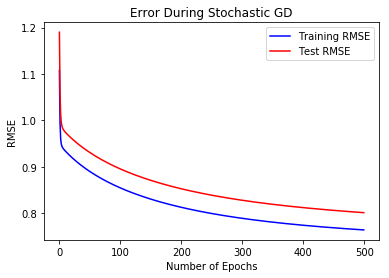

In [13]:
lfm = LFM(train_matrix, test_matrix)
lfm.initialize(k=12)
lr = 0.0000001
reg = 1.5
trg_err, test_err = lfm.train(lr, lr, reg, reg, 500)
lfm.trainplot()

current training error: 1.1070308414407162
current test error: 1.1844258459715125
Run took 13.32 seconds for epoch 0
current training error: 0.993551337701007
current test error: 1.0525389792094304
Run took 15.63 seconds for epoch 1
current training error: 0.9595393979661674
current test error: 1.0074159764465285
Run took 15.46 seconds for epoch 2
current training error: 0.9479943461899693
current test error: 0.9900067480413733
Run took 15.22 seconds for epoch 3
current training error: 0.9431087518217353
current test error: 0.9821254390215156
Run took 19.58 seconds for epoch 4
current training error: 0.9403841144058291
current test error: 0.977874925204646
Run took 16.63 seconds for epoch 5
current training error: 0.9384408878519805
current test error: 0.9751540011312434
Run took 23.72 seconds for epoch 6
current training error: 0.9368167818016481
current test error: 0.973137001048681
Run took 15.04 seconds for epoch 7
current training error: 0.9353419461052109
current test error: 0.97

current training error: 0.8780370496955079
current test error: 0.9152292232026168
Run took 13.39 seconds for epoch 70
current training error: 0.8773912206415925
current test error: 0.9145904260471572
Run took 13.07 seconds for epoch 71
current training error: 0.8767512431702182
current test error: 0.9139572096200348
Run took 13.21 seconds for epoch 72
current training error: 0.876117029273709
current test error: 0.9133294918615554
Run took 13.01 seconds for epoch 73
current training error: 0.8754884928342817
current test error: 0.9127071924545159
Run took 13.30 seconds for epoch 74
current training error: 0.8748655495740587
current test error: 0.9120902327783944
Run took 13.16 seconds for epoch 75
current training error: 0.8742481170065504
current test error: 0.9114785358648864
Run took 12.93 seconds for epoch 76
current training error: 0.8736361143895645
current test error: 0.9108720263547366
Run took 14.31 seconds for epoch 77
current training error: 0.8730294626795039
current test e

current training error: 0.843420255444826
current test error: 0.8806785899153589
Run took 14.13 seconds for epoch 140
current training error: 0.843042321046971
current test error: 0.8802977093555439
Run took 15.54 seconds for epoch 141
current training error: 0.8426668478962918
current test error: 0.879919226713041
Run took 13.69 seconds for epoch 142
current training error: 0.8422938111144737
current test error: 0.8795431183791597
Run took 12.95 seconds for epoch 143
current training error: 0.8419231861853497
current test error: 0.879169361083028
Run took 13.03 seconds for epoch 144
current training error: 0.8415549489476809
current test error: 0.8787979318849116
Run took 13.00 seconds for epoch 145
current training error: 0.8411890755881121
current test error: 0.8784288081696947
Run took 12.89 seconds for epoch 146
current training error: 0.8408255426342998
current test error: 0.87806196764052
Run took 12.89 seconds for epoch 147
current training error: 0.8404643269482095
current tes

current training error: 0.8218100910721609
current test error: 0.8587615211990681
Run took 12.98 seconds for epoch 210
current training error: 0.8215592097996295
current test error: 0.8585053609670552
Run took 12.95 seconds for epoch 211
current training error: 0.8213096456663069
current test error: 0.8582505049738128
Run took 12.92 seconds for epoch 212
current training error: 0.8210613882230944
current test error: 0.8579969431325061
Run took 13.10 seconds for epoch 213
current training error: 0.8208144271305494
current test error: 0.8577446654598144
Run took 12.99 seconds for epoch 214
current training error: 0.8205687521573284
current test error: 0.8574936620744821
Run took 12.90 seconds for epoch 215
current training error: 0.8203243531786618
current test error: 0.8572439231958947
Run took 13.03 seconds for epoch 216
current training error: 0.8200812201748576
current test error: 0.8569954391426864
Run took 12.95 seconds for epoch 217
current training error: 0.8198393432298309
curre

current training error: 0.8071220344635308
current test error: 0.8436936036657459
Run took 12.90 seconds for epoch 279
current training error: 0.8069421856847421
current test error: 0.8435081864454541
Run took 12.96 seconds for epoch 280
current training error: 0.8067631281555032
current test error: 0.8433235623156216
Run took 12.86 seconds for epoch 281
current training error: 0.8065848564422892
current test error: 0.8431397259505935
Run took 12.94 seconds for epoch 282
current training error: 0.8064073651581365
current test error: 0.842956672069269
Run took 12.96 seconds for epoch 283
current training error: 0.8062306489621417
current test error: 0.8427743954346287
Run took 12.99 seconds for epoch 284
current training error: 0.8060547025589632
current test error: 0.8425928908532686
Run took 12.77 seconds for epoch 285
current training error: 0.8058795206983353
current test error: 0.8424121531749418
Run took 12.98 seconds for epoch 286
current training error: 0.8057050981745841
curren

current training error: 0.796319384959161
current test error: 0.8325152610030353
Run took 12.81 seconds for epoch 348
current training error: 0.7961834566639857
current test error: 0.8323740610935011
Run took 12.89 seconds for epoch 349
current training error: 1.1071407672324927
current test error: 1.1861337874331428
Run took 12.91 seconds for epoch 0
current training error: 0.994061522002191
current test error: 1.0546922053467245
Run took 12.78 seconds for epoch 1
current training error: 0.9600979627547577
current test error: 1.0096668122620522
Run took 12.96 seconds for epoch 2
current training error: 0.9484957102121175
current test error: 0.9922286158788931
Run took 12.80 seconds for epoch 3
current training error: 0.9435328328176402
current test error: 0.9842819595417129
Run took 12.90 seconds for epoch 4
current training error: 0.9407326260636134
current test error: 0.9799571775005074
Run took 12.74 seconds for epoch 5
current training error: 0.9387187279494187
current test error:

current training error: 0.876821951886057
current test error: 0.9154475588854007
Run took 12.94 seconds for epoch 68
current training error: 0.8761298608368268
current test error: 0.9147591691088098
Run took 12.87 seconds for epoch 69
current training error: 0.8754440227368983
current test error: 0.9140767780275785
Run took 12.85 seconds for epoch 70
current training error: 0.8747643429542441
current test error: 0.9134002971537053
Run took 13.02 seconds for epoch 71
current training error: 0.8740907289407814
current test error: 0.912729639908824
Run took 12.91 seconds for epoch 72
current training error: 0.8734230901756603
current test error: 0.9120647215735705
Run took 12.79 seconds for epoch 73
current training error: 0.8727613381102749
current test error: 0.911405459238387
Run took 12.83 seconds for epoch 74
current training error: 0.8721053861149329
current test error: 0.910751771755733
Run took 12.79 seconds for epoch 75
current training error: 0.8714551494271349
current test erro

current training error: 0.8396936905958913
current test error: 0.8781909544648469
Run took 12.82 seconds for epoch 138
current training error: 0.8392881244607827
current test error: 0.8777801279605983
Run took 12.90 seconds for epoch 139
current training error: 0.8388852045542741
current test error: 0.8773718937612772
Run took 12.95 seconds for epoch 140
current training error: 0.8384849046425951
current test error: 0.8769662267597346
Run took 12.87 seconds for epoch 141
current training error: 0.8380871988742332
current test error: 0.8765631022082854
Run took 12.92 seconds for epoch 142
current training error: 0.8376920617721574
current test error: 0.8761624957114938
Run took 12.88 seconds for epoch 143
current training error: 0.8372994682262392
current test error: 0.8757643832191347
Run took 12.95 seconds for epoch 144
current training error: 0.8369093934858627
current test error: 0.8753687410193312
Run took 12.92 seconds for epoch 145
current training error: 0.8365218131527202
curre

current training error: 0.8168049308548856
current test error: 0.8548568351492506
Run took 12.98 seconds for epoch 207
current training error: 0.8165353987699507
current test error: 0.8545801197890608
Run took 12.85 seconds for epoch 208
current training error: 0.8162673148153097
current test error: 0.8543048424512864
Run took 12.86 seconds for epoch 209
current training error: 0.8160006677596244
current test error: 0.8540309922286297
Run took 12.87 seconds for epoch 210
current training error: 0.8157354464875375
current test error: 0.8537585583245063
Run took 12.87 seconds for epoch 211
current training error: 0.8154716399980221
current test error: 0.8534875300514877
Run took 12.90 seconds for epoch 212
current training error: 0.8152092374027656
current test error: 0.8532178968297754
Run took 12.96 seconds for epoch 213
current training error: 0.8149482279245827
current test error: 0.8529496481857032
Run took 13.01 seconds for epoch 214
current training error: 0.8146886008958582
curre

current training error: 0.8009098943512595
current test error: 0.83844837930891
Run took 14.24 seconds for epoch 277
current training error: 0.800719747595393
current test error: 0.8382509021989707
Run took 14.44 seconds for epoch 278
current training error: 0.8005304745406586
current test error: 0.8380543023629263
Run took 14.28 seconds for epoch 279
current training error: 0.8003420693170635
current test error: 0.837858574034468
Run took 14.15 seconds for epoch 280
current training error: 0.8001545261036249
current test error: 0.8376637114945532
Run took 15.43 seconds for epoch 281
current training error: 0.799967839127854
current test error: 0.8374697090709124
Run took 12.98 seconds for epoch 282
current training error: 0.7997820026652414
current test error: 0.8372765611375579
Run took 12.84 seconds for epoch 283
current training error: 0.7995970110387529
current test error: 0.8370842621143064
Run took 12.97 seconds for epoch 284
current training error: 0.7994128586183329
current te

current training error: 0.7894277542291375
current test error: 0.8264660735353982
Run took 12.90 seconds for epoch 347
current training error: 0.7892868705344223
current test error: 0.8263182831830768
Run took 12.81 seconds for epoch 348
current training error: 0.7891465449333261
current test error: 0.8261710586073555
Run took 12.90 seconds for epoch 349
current training error: 1.1070235026597988
current test error: 1.1870194487044246
Run took 12.82 seconds for epoch 0
current training error: 0.9937497433744085
current test error: 1.0551892920071897
Run took 12.96 seconds for epoch 1
current training error: 0.959771791737302
current test error: 1.0099612249290135
Run took 12.80 seconds for epoch 2
current training error: 0.9481976972096398
current test error: 0.9924013970561052
Run took 12.80 seconds for epoch 3
current training error: 0.9432640652406196
current test error: 0.9843729092407404
Run took 12.79 seconds for epoch 4
current training error: 0.9404882048511998
current test err

current training error: 0.8779981382081193
current test error: 0.9161999269069792
Run took 12.83 seconds for epoch 67
current training error: 0.8773057947278559
current test error: 0.9155054268842645
Run took 12.86 seconds for epoch 68
current training error: 0.8766196887902892
current test error: 0.9148169180952325
Run took 12.77 seconds for epoch 69
current training error: 0.8759397255213873
current test error: 0.9141343113581731
Run took 12.88 seconds for epoch 70
current training error: 0.8752658121471892
current test error: 0.9134575194509736
Run took 12.80 seconds for epoch 71
current training error: 0.8745978579365876
current test error: 0.9127864570575802
Run took 12.82 seconds for epoch 72
current training error: 0.8739357741458411
current test error: 0.9121210407161223
Run took 12.73 seconds for epoch 73
current training error: 0.8732794739647591
current test error: 0.911461188768639
Run took 12.89 seconds for epoch 74
current training error: 0.8726288724645084
current test e

current training error: 0.8408117618225328
current test error: 0.8784856433152359
Run took 12.72 seconds for epoch 137
current training error: 0.8404048201202794
current test error: 0.8780678799658104
Run took 12.84 seconds for epoch 138
current training error: 0.8400005123426895
current test error: 0.8776527022159515
Run took 12.81 seconds for epoch 139
current training error: 0.8395988124134316
current test error: 0.8772400852006846
Run took 12.86 seconds for epoch 140
current training error: 0.8391996946385845
current test error: 0.8768300044145129
Run took 12.78 seconds for epoch 141
current training error: 0.8388031336987978
current test error: 0.8764224357040901
Run took 12.85 seconds for epoch 142
current training error: 0.838409104641653
current test error: 0.87601735526108
Run took 12.72 seconds for epoch 143
current training error: 0.8380175828742168
current test error: 0.8756147396151908
Run took 12.86 seconds for epoch 144
current training error: 0.8376285441557814
current 

current training error: 0.8175357063466526
current test error: 0.8543854251063802
Run took 12.83 seconds for epoch 207
current training error: 0.8172657378519436
current test error: 0.85410326606423
Run took 12.87 seconds for epoch 208
current training error: 0.816997203419787
current test error: 0.8538225412223355
Run took 12.76 seconds for epoch 209
current training error: 0.8167300920338685
current test error: 0.8535432399150754
Run took 12.84 seconds for epoch 210
current training error: 0.8164643927910993
current test error: 0.8532653515840827
Run took 12.74 seconds for epoch 211
current training error: 0.8162000949000022
current test error: 0.8529888657767264
Run took 12.81 seconds for epoch 212
current training error: 0.8159371876791307
current test error: 0.8527137721446278
Run took 12.75 seconds for epoch 213
current training error: 0.8156756605555155
current test error: 0.8524400604421999
Run took 12.80 seconds for epoch 214
current training error: 0.8154155030631423
current 

current training error: 0.8015857639591418
current test error: 0.8375971757544086
Run took 12.90 seconds for epoch 277
current training error: 0.8013945918806599
current test error: 0.8373944140766876
Run took 12.87 seconds for epoch 278
current training error: 0.8012042893968008
current test error: 0.8371925362823571
Run took 12.83 seconds for epoch 279
current training error: 0.8010148507239039
current test error: 0.8369915366824996
Run took 12.78 seconds for epoch 280
current training error: 0.8008262701261762
current test error: 0.8367914096340143
Run took 12.83 seconds for epoch 281
current training error: 0.8006385419151872
current test error: 0.8365921495391377
Run took 12.80 seconds for epoch 282
current training error: 0.8004516604493707
current test error: 0.8363937508449765
Run took 12.89 seconds for epoch 283
current training error: 0.8002656201335326
current test error: 0.8361962080430432
Run took 12.80 seconds for epoch 284
current training error: 0.8000804154183683
curre

current training error: 0.790168361962157
current test error: 0.8254170891486999
Run took 12.82 seconds for epoch 346
current training error: 0.7900257611576067
current test error: 0.8252640208014828
Run took 12.76 seconds for epoch 347
current training error: 0.7898837216389873
current test error: 0.8251115309916903
Run took 12.85 seconds for epoch 348
current training error: 0.7897422400242387
current test error: 0.8249596163419878
Run took 12.92 seconds for epoch 349
current training error: 1.1074754631529402
current test error: 1.1843178816118072
Run took 12.95 seconds for epoch 0
current training error: 0.993942509202921
current test error: 1.0517893761910142
Run took 12.83 seconds for epoch 1
current training error: 0.9598740814994648
current test error: 1.006286004037372
Run took 12.90 seconds for epoch 2
current training error: 0.9483022056064315
current test error: 0.9886180202535118
Run took 12.90 seconds for epoch 3
current training error: 0.9433964523975785
current test err

current training error: 0.8800953822870687
current test error: 0.9134648722927301
Run took 12.94 seconds for epoch 66
current training error: 0.8794189160397538
current test error: 0.9127807698402223
Run took 12.82 seconds for epoch 67
current training error: 0.8787487775099476
current test error: 0.9121028671192006
Run took 12.94 seconds for epoch 68
current training error: 0.8780848670455981
current test error: 0.9114310686023346
Run took 12.79 seconds for epoch 69
current training error: 0.8774270872327052
current test error: 0.9107652808749419
Run took 12.85 seconds for epoch 70
current training error: 0.8767753428341684
current test error: 0.9101054125775809
Run took 12.92 seconds for epoch 71
current training error: 0.8761295407304731
current test error: 0.9094513743504171
Run took 12.90 seconds for epoch 72
current training error: 0.8754895898621698
current test error: 0.9088030787792951
Run took 12.81 seconds for epoch 73
current training error: 0.8748554011740767
current test 

current training error: 0.8440673028318502
current test error: 0.8767389493093439
Run took 12.91 seconds for epoch 136
current training error: 0.8436759998088798
current test error: 0.8763366460595259
Run took 12.86 seconds for epoch 137
current training error: 0.8432872788633917
current test error: 0.8759369194102258
Run took 12.86 seconds for epoch 138
current training error: 0.8429011133898004
current test error: 0.8755397433087205
Run took 12.88 seconds for epoch 139
current training error: 0.8425174771844944
current test error: 0.8751450920902581
Run took 12.82 seconds for epoch 140
current training error: 0.8421363444374834
current test error: 0.8747529404701024
Run took 12.83 seconds for epoch 141
current training error: 0.8417576897242569
current test error: 0.8743632635357755
Run took 12.88 seconds for epoch 142
current training error: 0.8413814879978512
current test error: 0.8739760367394958
Run took 12.87 seconds for epoch 143
current training error: 0.8410077145811158
curre

current training error: 0.8220048217093752
current test error: 0.8539247641783061
Run took 12.84 seconds for epoch 205
current training error: 0.8217449271629981
current test error: 0.8536542939953172
Run took 12.87 seconds for epoch 206
current training error: 0.8214864170720871
current test error: 0.8533852213740052
Run took 12.79 seconds for epoch 207
current training error: 0.82122928040468
current test error: 0.853117535385367
Run took 12.85 seconds for epoch 208
current training error: 0.8209735062467867
current test error: 0.8528512252157924
Run took 12.82 seconds for epoch 209
current training error: 0.8207190838006552
current test error: 0.8525862801653821
Run took 12.82 seconds for epoch 210
current training error: 0.8204660023830762
current test error: 0.8523226896463019
Run took 12.92 seconds for epoch 211
current training error: 0.8202142514237144
current test error: 0.8520604431811667
Run took 12.85 seconds for epoch 212
current training error: 0.8199638204634789
current 

current training error: 0.8066426118816338
current test error: 0.8378576760555541
Run took 12.85 seconds for epoch 275
current training error: 0.8064581810127436
current test error: 0.8376637301439571
Run took 13.01 seconds for epoch 276
current training error: 0.8062745759144936
current test error: 0.8374706260792861
Run took 12.94 seconds for epoch 277
current training error: 0.8060917909392579
current test error: 0.8372783582150918
Run took 12.87 seconds for epoch 278
current training error: 0.8059098204878637
current test error: 0.8370869209526388
Run took 12.83 seconds for epoch 279
current training error: 0.8057286590090634
current test error: 0.83689630874039
Run took 12.95 seconds for epoch 280
current training error: 0.8055483009990076
current test error: 0.8367065160734941
Run took 12.88 seconds for epoch 281
current training error: 0.8053687410007365
current test error: 0.8365175374932843
Run took 12.83 seconds for epoch 282
current training error: 0.8051899736036688
current

current training error: 0.795594954908808
current test error: 0.8261907366954212
Run took 12.81 seconds for epoch 344
current training error: 0.7954564050160078
current test error: 0.8260437538379601
Run took 12.94 seconds for epoch 345
current training error: 0.7953183824228376
current test error: 0.82589731321089
Run took 12.90 seconds for epoch 346
current training error: 0.7951808838866754
current test error: 0.8257514115427749
Run took 12.92 seconds for epoch 347
current training error: 0.7950439061893009
current test error: 0.8256060455863717
Run took 12.90 seconds for epoch 348
current training error: 0.794907446136675
current test error: 0.8254612121184124
Run took 12.93 seconds for epoch 349
current training error: 1.106425749635855
current test error: 1.181793496955365
Run took 12.88 seconds for epoch 0
current training error: 0.99310807810921
current test error: 1.049640750044497
Run took 12.89 seconds for epoch 1
current training error: 0.9591593082311171
current test error

current training error: 0.8808018777860102
current test error: 0.9142906733488808
Run took 12.85 seconds for epoch 64
current training error: 0.8801065798692298
current test error: 0.9136023983265876
Run took 12.91 seconds for epoch 65
current training error: 0.8794177601411225
current test error: 0.912920348504942
Run took 12.81 seconds for epoch 66
current training error: 0.8787353173781126
current test error: 0.9122444282063092
Run took 12.84 seconds for epoch 67
current training error: 0.8780591526151037
current test error: 0.911574543876379
Run took 12.98 seconds for epoch 68
current training error: 0.8773891690840897
current test error: 0.9109106040252865
Run took 12.81 seconds for epoch 69
current training error: 0.8767252721546142
current test error: 0.9102525191706996
Run took 12.89 seconds for epoch 70
current training error: 0.8760673692760187
current test error: 0.9096002017827827
Run took 12.86 seconds for epoch 71
current training error: 0.8754153699214227
current test er

current training error: 0.8437490478388029
current test error: 0.877329006924148
Run took 12.81 seconds for epoch 134
current training error: 0.8433465726668031
current test error: 0.8769240987165979
Run took 12.86 seconds for epoch 135
current training error: 0.8429467578821176
current test error: 0.8765217868374253
Run took 12.91 seconds for epoch 136
current training error: 0.8425495762502474
current test error: 0.8761220451651985
Run took 12.93 seconds for epoch 137
current training error: 0.8421550009462485
current test error: 0.8757248479667109
Run took 12.84 seconds for epoch 138
current training error: 0.8417630055462609
current test error: 0.8753301698890242
Run took 13.08 seconds for epoch 139
current training error: 0.8413735640192466
current test error: 0.8749379859517077
Run took 12.88 seconds for epoch 140
current training error: 0.8409866507189384
current test error: 0.8745482715392724
Run took 12.93 seconds for epoch 141
current training error: 0.8406022403759928
curren

current training error: 0.8208050246447809
current test error: 0.8541060712890242
Run took 12.97 seconds for epoch 204
current training error: 0.8205396296169051
current test error: 0.8538356189922446
Run took 12.79 seconds for epoch 205
current training error: 0.8202756554764504
current test error: 0.8535665686452281
Run took 12.89 seconds for epoch 206
current training error: 0.8200130910042355
current test error: 0.8532989093744957
Run took 12.90 seconds for epoch 207
current training error: 0.8197519250999126
current test error: 0.853032630420322
Run took 12.91 seconds for epoch 208
current training error: 0.8194921467802402
current test error: 0.8527677211350911
Run took 12.85 seconds for epoch 209
current training error: 0.8192337451773769
current test error: 0.8525041709816781
Run took 12.86 seconds for epoch 210
current training error: 0.8189767095372201
current test error: 0.852241969531863
Run took 12.94 seconds for epoch 211
current training error: 0.8187210292177673
current

current training error: 0.8053249245599647
current test error: 0.8382470934823801
Run took 12.80 seconds for epoch 273
current training error: 0.805136279438833
current test error: 0.8380526869139351
Run took 12.94 seconds for epoch 274
current training error: 0.8049484911860987
current test error: 0.8378591335061047
Run took 12.90 seconds for epoch 275
current training error: 0.8047615539708401
current test error: 0.8376664275571228
Run took 12.91 seconds for epoch 276
current training error: 0.8045754620117805
current test error: 0.8374745634130443
Run took 12.85 seconds for epoch 277
current training error: 0.8043902095767453
current test error: 0.8372835354672284
Run took 12.88 seconds for epoch 278
current training error: 0.8042057909821323
current test error: 0.8370933381598312
Run took 12.99 seconds for epoch 279
current training error: 0.8040222005923835
current test error: 0.836903965977304
Run took 12.91 seconds for epoch 280
current training error: 0.8038394328194703
current

current training error: 0.7940507608717987
current test error: 0.826572117557937
Run took 12.95 seconds for epoch 342
current training error: 0.7939097670425213
current test error: 0.8264253314707753
Run took 12.82 seconds for epoch 343
current training error: 0.793769321303279
current test error: 0.8262790954172953
Run took 12.95 seconds for epoch 344
current training error: 0.7936294202913602
current test error: 0.8261334060804363
Run took 12.88 seconds for epoch 345
current training error: 0.7934900606691583
current test error: 0.8259882601674932
Run took 12.87 seconds for epoch 346
current training error: 0.7933512391239443
current test error: 0.8258436544099003
Run took 12.92 seconds for epoch 347
current training error: 0.7932129523676482
current test error: 0.825699585563017
Run took 12.81 seconds for epoch 348
current training error: 0.7930751971366343
current test error: 0.825556050405919
Run took 12.87 seconds for epoch 349
RMSE on test set for latent factor model after 5-fol

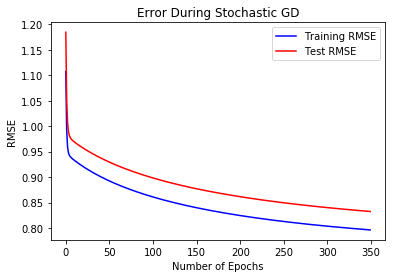

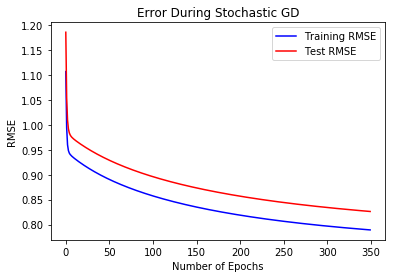

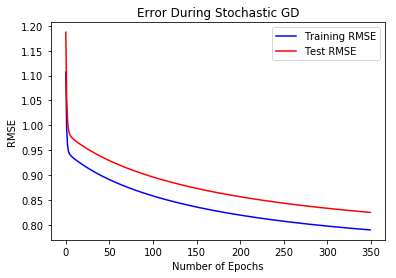

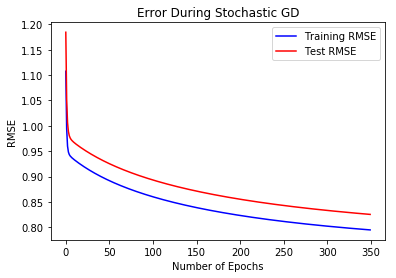

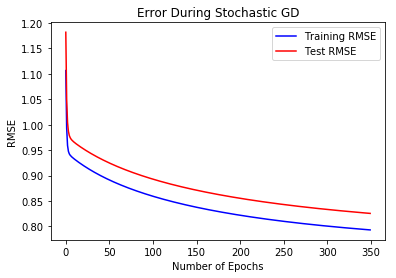

In [60]:
RMSE = 0
i = 1
for train, test in km.split(cv_ratings):
    trainset = cv_ratings.iloc[train, :]
    testset = cv_ratings.iloc[test, :]
    
    train_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
    #val_matrix = valset.pivot(index='userId', columns='movieId', values='rating')
    test_matrix = testset.pivot(index='userId', columns='movieId', values='rating')
    lfm = LFM(train_matrix, test_matrix)
    lfm.initialize(k=12)
    lr = 0.0000001
    reg = 1.5
    trg_err, test_err = lfm.train(lr, lr, reg, reg, 350)
    RMSE += test_err
    lfm.trainplot()
RMSE = RMSE / 5
print('RMSE on test set for latent factor model after 5-fold CV is ' + str(RMSE))

In [91]:
lfm.pred_forall()

In [177]:
lfm.recommend(116, 10)

['Iron Man',
 'Dark Knight, The',
 'No Country for Old Men',
 'Casino Royale',
 'Prestige, The',
 'Children of Men',
 'Departed, The',
 'Little Miss Sunshine',
 'V for Vendetta',
 'King Kong']

In [137]:
lfm_testset = testset

lfm_testset['pred'] = lfm_testset.apply(lambda x: lfm.pred.loc[x["userId"], x["movieId"]], axis=1)

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [164]:
def recall_lfm():
    #like = pred_rating_lfm[[movieid]][pred_rating_lfm[movieid] == 1].index.tolist()
    #real = true_rating_lfm[[movieid]][true_rating_lfm[movieid] == 1].index.tolist()
    like = lfm_testset[lfm_testset['pred'] >= 3].index.tolist()
    real = lfm_testset[lfm_testset['rating'] >= 3].index.tolist()
    correct = len(set(like).intersection(set(real)))   
    return correct / (len(real) + 0.0001)
def precision_lfm():
    #like = pred_rating_lfm[[movieid]][pred_rating_lfm[movieid] == 1].index.tolist()
    #real = true_rating_lfm[[movieid]][true_rating_lfm[movieid] == 1].index.tolist()
    like = lfm_testset[lfm_testset['pred'] >= 3].index.tolist()
    real = lfm_testset[lfm_testset['rating'] > 3].index.tolist()
    correct = len(set(like).intersection(set(real))) 
    return correct / (len(like) + 0.0001)

In [165]:
recall = recall_lfm()
precision = precision_lfm()
#for id in lfm_testset['movieId']:
#    recall += recall_lfm(id)
#    precision += precision_lfm(id)
    #print(precision_lfm(id))

#recall = recall / pred_rating_lfm.shape[1]
#precision = precision / pred_rating_lfm.shape[1]
print('Recall rate for latent factor model is: ' + str(recall))
print('Precision rate for latent factor model is: ' + str(precision))

Recall rate for latent factor model is: 0.8226860754879769
Precision rate for latent factor model is: 0.9133049706216657


In [14]:
class LFM_bias(object):
    ''' This class built a recommender system based on latent factor model with 
    stochastic gradient descent'''
    
    def __init__(self, train, test):
        self.ids = train.index
        self.columns = train.columns
        self.R = train.fillna(0).values
        self.T = test.fillna(0).values
        self.Q = None
        self.P = None
    
    def initialize(self, Q=None, P=None, k=1):
        '''initialize Q, P and latent factor k. The default values for Q and P
        are the results for SVD for R'''
        if (Q is not None) and (P is not None):
            self.Q = Q
            self.P = P
        else:
            u, s, vt = svds(self.R, k=k)
            s_diag=np.diag(s)
            self.Q = u
            self.P = s_diag.dot(vt).T
            
    def rmse_(self, R, Q, P, Bx, Bi, mu):
       # prediction = Q.dot(P.T)
       # prediction = prediction[R.nonzero()].flatten() 
       # true_value = R[R.nonzero()].flatten()
       # return math.sqrt(mean_squared_error(prediction, true_value))
        I = R != 0  # Indicator function which is zero for missing data
        ME = I * (R - (Bx + Bi - mu + np.dot(Q, P.T))) # Errors between real and predicted ratings
        MSE = ME**2  
        return np.sqrt(np.sum(MSE)/np.sum(I))
    @autojit
    def train(self, lr1, lr2, reg1, reg2, maxiter):
        '''SGD for training
        @lr1: learning rate for Q   @lr2: learning rate for P
        @reg1: regularizer for Q    @reg2: regularizer for P
        @maxiter: stop when epochs exceed this value
        '''
        
        train_errors = []
        test_errors = []
        users,items = self.R.nonzero() 
        for epoch in range(maxiter):
            # Include Bias term
            self.mu = self.R.mean().mean()
            bx = self.R.mean(axis=1)
            bi = self.R.mean(axis=0)
            self.Bx = np.tile(bx, self.R.shape[1]).reshape(self.R.shape[0], self.R.shape[1])
            self.Bi = np.tile(bi, self.R.shape[0]).reshape(self.R.shape[0], self.R.shape[1])
            dR = 2 * (self.R - (self.Bx + self.Bi - self.mu + self.Q.dot(self.P.T)))
            
            start_time = default_timer()
            for u, i in zip(users, items):
                dq = dR[u, i] * self.P[i, :] - 2 * reg2 * self.Q[u, :]
                self.Q[u, :] += lr1 * dq
                dp = dR[u, i] * self.Q[u, :] - 2 * reg1 * self.P[i, :]
                self.P[i, :] += lr2 * dp
            
            trg_err = self.rmse_(self.R, self.Q, self.P, self.Bx, self.Bi, self.mu)
            print("current training error: " + str(trg_err))
            train_errors = train_errors + [trg_err]
            test_err = self.rmse_(self.T, self.Q, self.P, self.Bx, self.Bi, self.mu)
            print("current test error: " + str(test_err))
            test_errors = test_errors + [test_err]
            print("Run took %.2f seconds for epoch " % (default_timer() - start_time) + str(epoch))
        self.train_errors = train_errors
        self.test_errors = test_errors
        return self.train_errors[-1], self.test_errors[-1]
            
    def trainplot(self):
        
        # Check performance by plotting train and test errors
        fig, ax = plt.subplots()
        ax.plot(self.train_errors, color="b", label='Training RMSE')
        ax.plot(self.test_errors, color="r", label='Test RMSE')
        ax.set_title("Error During Stochastic GD")
        ax.set_xlabel("Number of Epochs")
        ax.set_ylabel("RMSE")
        ax.legend()
    def pred_forall(self):
        self.pred = pd.DataFrame(self.Bx + self.Bi - self.mu + self.Q.dot(self.P.T), index=self.ids, columns=self.columns)

        
    def recommend(self, userid, k):
        '''Input userid to recommend top k movies that this user might like most'''
        
        rec = list(self.pred.loc[userid, :].argsort()[-k:][::-1].index)
        
        return list(map(lambda x: nameDict[x], rec))

In [368]:
k_option = [5, 10, 15, 20]
train_errors = []
test_errors = []
lfm_bias = LFM_bias(train_matrix, test_matrix)
for k in k_option:
    lfm_bias.initialize(k=k)
    lr = 0.0000001
    reg = 1.5
    trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 30)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]

current training error: 1.1330703918446206
current test error: 1.1387665735262413
Run took 11.68 seconds for epoch 0
current training error: 1.075264057311119
current test error: 1.0896027068099323
Run took 10.92 seconds for epoch 1
current training error: 1.0623089176505196
current test error: 1.0801850228003682
Run took 11.06 seconds for epoch 2
current training error: 1.0586836754863627
current test error: 1.0781117102386557
Run took 11.15 seconds for epoch 3
current training error: 1.0571463686316953
current test error: 1.0773052552463838
Run took 11.10 seconds for epoch 4
current training error: 1.0561287638425412
current test error: 1.0766568014659077
Run took 12.08 seconds for epoch 5
current training error: 1.0552619471334006
current test error: 1.0759920087362131
Run took 12.61 seconds for epoch 6
current training error: 1.0544514650116292
current test error: 1.0753032537800928
Run took 12.04 seconds for epoch 7
current training error: 1.0536709206373869
current test error: 1.

current training error: 1.025115995260234
current test error: 1.074937638806732
Run took 10.98 seconds for epoch 10
current training error: 1.0238816679324831
current test error: 1.0737933212529036
Run took 11.25 seconds for epoch 11
current training error: 1.0226637191725845
current test error: 1.0726503919489856
Run took 11.04 seconds for epoch 12
current training error: 1.0214615626644297
current test error: 1.0715142557324144
Run took 10.95 seconds for epoch 13
current training error: 1.020274750707777
current test error: 1.0703877724735091
Run took 11.11 seconds for epoch 14
current training error: 1.019102900461348
current test error: 1.0692724291623035
Run took 10.93 seconds for epoch 15
current training error: 1.0179456644019944
current test error: 1.0681689616903312
Run took 11.02 seconds for epoch 16
current training error: 1.0168027174669618
current test error: 1.0670776894585938
Run took 10.92 seconds for epoch 17
current training error: 1.0156737508883857
current test erro

KeyboardInterrupt: 

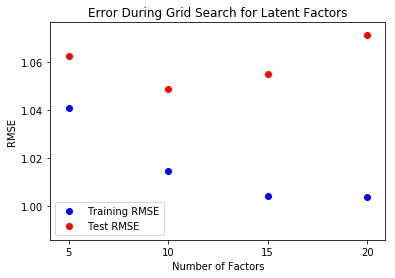

In [373]:
fig, ax = plt.subplots()
ax.scatter(k_option, train_errors, color="b", label='Training RMSE')
ax.scatter(k_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Latent Factors")
ax.set_xlabel("Number of Factors")
ax.set_ylabel("RMSE")
ax.set_xticks(k_option)
ax.legend()

In [408]:
reg_option = [0.5, 1, 1.5, 2.5, 4, 8, 10, 13, 15, 20, 22, 25, 30, 35, 40, 50, 60, 100]
train_errors = []
test_errors = []
lfm_bias = LFM_bias(train_matrix, test_matrix)
for reg in reg_option:
    lfm_bias.initialize(k=10)
    lr = 0.0000001
    trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 20)
    train_errors = train_errors + [trg_err]
    test_errors = test_errors + [test_err]

current training error: 1.108100081467136
current test error: 1.110953070759422
Run took 13.07 seconds for epoch 0
current training error: 1.0437203460022577
current test error: 1.0651310128218054
Run took 12.73 seconds for epoch 1
current training error: 1.0284276316238417
current test error: 1.057523875894173
Run took 12.70 seconds for epoch 2
current training error: 1.02231003444016
current test error: 1.0546992222162004
Run took 12.29 seconds for epoch 3
current training error: 1.0179533877719016
current test error: 1.0517705594037676
Run took 12.14 seconds for epoch 4
current training error: 1.013978053399014
current test error: 1.0483683635070968
Run took 12.11 seconds for epoch 5
current training error: 1.0101680410969316
current test error: 1.0447131479937743
Run took 11.71 seconds for epoch 6
current training error: 1.0065227050339618
current test error: 1.0410068231103264
Run took 11.72 seconds for epoch 7
current training error: 1.00306735668444
current test error: 1.0373744

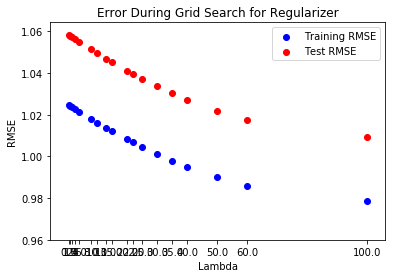

In [412]:
fig, ax = plt.subplots()
ax.scatter(reg_option, train_errors, color="b", label='Training RMSE')
ax.scatter(reg_option, test_errors, color="r", label='Test RMSE')
ax.set_title("Error During Grid Search for Regularizer")
ax.set_xlabel("Lambda")
ax.set_ylabel("RMSE")
ax.set_xticks(reg_option)
ax.legend()

In [377]:
train_temp = train_errors
test_temp = test_errors

current training error: 1.1282436449444484
current test error: 1.1248297923999973
Run took 14.98 seconds for epoch 0
current training error: 1.0614704967098367
current test error: 1.0757076443004165
Run took 14.89 seconds for epoch 1
current training error: 1.0456986916891433
current test error: 1.0678713867437837
Run took 15.10 seconds for epoch 2
current training error: 1.0407963708993921
current test error: 1.066609354197037
Run took 14.83 seconds for epoch 3
current training error: 1.0383648283247724
current test error: 1.065920066829945
Run took 14.84 seconds for epoch 4
current training error: 1.036550234189299
current test error: 1.0649751382880446
Run took 14.86 seconds for epoch 5
current training error: 1.034913806915735
current test error: 1.0637915314472175
Run took 14.84 seconds for epoch 6
current training error: 1.0333453033822777
current test error: 1.0624698138799031
Run took 14.92 seconds for epoch 7
current training error: 1.031815741457279
current test error: 1.0610

current training error: 0.9733035018764243
current test error: 1.0023746851322146
Run took 14.71 seconds for epoch 70
current training error: 0.972716308109909
current test error: 1.0017675271291102
Run took 14.86 seconds for epoch 71
current training error: 0.9721359930749345
current test error: 1.0011670473444625
Run took 14.76 seconds for epoch 72
current training error: 0.9715624301638098
current test error: 1.0005731254657972
Run took 14.88 seconds for epoch 73
current training error: 0.9709954958452898
current test error: 0.9999856440585462
Run took 14.85 seconds for epoch 74
current training error: 0.9704350695732377
current test error: 0.9994044884815605
Run took 14.93 seconds for epoch 75
current training error: 0.969881033698445
current test error: 0.9988295468055229
Run took 14.78 seconds for epoch 76
current training error: 0.9693332733834834
current test error: 0.9982607097341428
Run took 14.85 seconds for epoch 77
current training error: 0.968791676520474
current test err

current training error: 0.9439012766677835
current test error: 0.9713116692617967
Run took 14.87 seconds for epoch 140
current training error: 0.943601212486622
current test error: 0.9709860740672261
Run took 14.90 seconds for epoch 141
current training error: 0.9433034842965704
current test error: 0.9706627992329125
Run took 14.77 seconds for epoch 142
current training error: 0.9430080623830625
current test error: 0.9703418158537863
Run took 14.83 seconds for epoch 143
current training error: 0.9427149175473408
current test error: 0.97002309551898
Run took 16.43 seconds for epoch 144
current training error: 0.9424240210955009
current test error: 0.9697066103014891
Run took 15.09 seconds for epoch 145
current training error: 0.9421353448278131
current test error: 0.9693923327480938
Run took 14.75 seconds for epoch 146
current training error: 0.9418488610283212
current test error: 0.9690802358695336
Run took 14.91 seconds for epoch 147
current training error: 0.9415645424546933
current 

current training error: 0.927469408656833
current test error: 0.9531104330417818
Run took 14.96 seconds for epoch 209
current training error: 0.927280750008087
current test error: 0.9528963104058807
Run took 15.30 seconds for epoch 210
current training error: 0.9270931863908265
current test error: 0.9526832934477797
Run took 14.85 seconds for epoch 211
current training error: 0.9269067076772723
current test error: 0.9524713721833972
Run took 14.90 seconds for epoch 212
current training error: 0.9267213038809873
current test error: 0.9522605367668187
Run took 14.92 seconds for epoch 213
current training error: 0.926536965154576
current test error: 0.952050777488081
Run took 14.84 seconds for epoch 214
current training error: 0.9263536817874294
current test error: 0.9518420847710036
Run took 14.82 seconds for epoch 215
current training error: 0.9261714442035158
current test error: 0.9516344491710568
Run took 14.79 seconds for epoch 216
current training error: 0.9259902429592142
current t

current training error: 0.9165911173574566
current test error: 0.9405056278699169
Run took 14.72 seconds for epoch 278
current training error: 0.9164600821920136
current test error: 0.9403500881503344
Run took 14.74 seconds for epoch 279
current training error: 0.9163296844237722
current test error: 0.9401952019734239
Run took 14.78 seconds for epoch 280
current training error: 0.9161999199915356
current test error: 0.9400409653220857
Run took 14.80 seconds for epoch 281
current training error: 0.916070784885611
current test error: 0.9398873742302525
Run took 14.96 seconds for epoch 282
current training error: 0.9159422751471465
current test error: 0.9397344247822401
Run took 14.78 seconds for epoch 283
current training error: 0.9158143868674811
current test error: 0.9395821131121096
Run took 14.85 seconds for epoch 284
current training error: 0.9156871161875025
current test error: 0.9394304354030378
Run took 16.28 seconds for epoch 285
current training error: 0.9155604592970187
curren

current training error: 0.9866283155752896
current test error: 1.0173451722691849
Run took 15.12 seconds for epoch 48
current training error: 0.9858443380748663
current test error: 1.0165494130456634
Run took 15.27 seconds for epoch 49
current training error: 0.9850712401266791
current test error: 1.015764148883836
Run took 14.88 seconds for epoch 50
current training error: 0.9843087885662131
current test error: 1.0149891595149867
Run took 15.02 seconds for epoch 51
current training error: 0.9835567567437705
current test error: 1.014224230717375
Run took 14.94 seconds for epoch 52
current training error: 0.9828149243053681
current test error: 1.0134691541162624
Run took 14.99 seconds for epoch 53
current training error: 0.9820830769820659
current test error: 1.0127237269914577
Run took 14.86 seconds for epoch 54
current training error: 0.9813610063873766
current test error: 1.011987752092082
Run took 14.88 seconds for epoch 55
current training error: 0.9806485098224007
current test err

current training error: 0.9493735125734103
current test error: 0.9787668879908481
Run took 14.91 seconds for epoch 118
current training error: 0.9490129258866612
current test error: 0.9783838623629684
Run took 14.87 seconds for epoch 119
current training error: 0.9486555055959748
current test error: 0.9780039645599207
Run took 14.94 seconds for epoch 120
current training error: 0.9483012065871919
current test error: 0.9776271507685923
Run took 15.02 seconds for epoch 121
current training error: 0.9479499846129498
current test error: 0.9772533780047241
Run took 14.90 seconds for epoch 122
current training error: 0.9476017962721567
current test error: 0.976882604093569
Run took 15.04 seconds for epoch 123
current training error: 0.9472565989900392
current test error: 0.9765147876510949
Run took 14.96 seconds for epoch 124
current training error: 0.9469143509987581
current test error: 0.9761498880657075
Run took 14.94 seconds for epoch 125
current training error: 0.9465750113185636
curren

current training error: 0.9301300611685338
current test error: 0.957929785054547
Run took 14.93 seconds for epoch 187
current training error: 0.9299146115093668
current test error: 0.9576910050656409
Run took 14.81 seconds for epoch 188
current training error: 0.9297005232617495
current test error: 0.9574535877594206
Run took 15.05 seconds for epoch 189
current training error: 0.9294877824221195
current test error: 0.957217519326056
Run took 14.93 seconds for epoch 190
current training error: 0.9292763751949635
current test error: 0.9569827861588586
Run took 15.24 seconds for epoch 191
current training error: 0.9290662879891352
current test error: 0.9567493748507315
Run took 14.83 seconds for epoch 192
current training error: 0.92885750741425
current test error: 0.9565172721906998
Run took 15.02 seconds for epoch 193
current training error: 0.9286500202771573
current test error: 0.956286465160509
Run took 14.88 seconds for epoch 194
current training error: 0.9284438135784898
current te

current training error: 0.9177244198211292
current test error: 0.9439014360585842
Run took 14.89 seconds for epoch 257
current training error: 0.9175792106367858
current test error: 0.94373327366122
Run took 14.89 seconds for epoch 258
current training error: 0.9174347375116448
current test error: 0.9435658551965392
Run took 14.82 seconds for epoch 259
current training error: 0.9172909951205749
current test error: 0.9433991753784194
Run took 14.96 seconds for epoch 260
current training error: 0.9171479782071069
current test error: 0.9432332289886591
Run took 15.45 seconds for epoch 261
current training error: 0.9170056815824812
current test error: 0.9430680108760437
Run took 14.74 seconds for epoch 262
current training error: 0.9168641001247093
current test error: 0.942903515955429
Run took 14.90 seconds for epoch 263
current training error: 0.9167232287776539
current test error: 0.9427397392068338
Run took 14.72 seconds for epoch 264
current training error: 0.9165830625501262
current 

current training error: 1.006722622650698
current test error: 1.0333537458598396
Run took 14.87 seconds for epoch 27
current training error: 1.0056298555691854
current test error: 1.0322445369289373
Run took 14.93 seconds for epoch 28
current training error: 1.0045547448890695
current test error: 1.0311523572559804
Run took 14.96 seconds for epoch 29
current training error: 1.0034968599783174
current test error: 1.0300768026183178
Run took 14.90 seconds for epoch 30
current training error: 1.0024557838651642
current test error: 1.0290174807899934
Run took 14.91 seconds for epoch 31
current training error: 1.001431112699916
current test error: 1.0279740112422573
Run took 14.84 seconds for epoch 32
current training error: 1.0004224552454035
current test error: 1.0269460248149282
Run took 14.93 seconds for epoch 33
current training error: 0.9994294323936908
current test error: 1.0259331633731634
Run took 14.83 seconds for epoch 34
current training error: 0.9984516767068812
current test er

current training error: 0.9575586522588236
current test error: 0.9823091195726583
Run took 14.97 seconds for epoch 97
current training error: 0.957110124686077
current test error: 0.981829528968395
Run took 14.84 seconds for epoch 98
current training error: 0.9566660567663099
current test error: 0.9813543791112334
Run took 14.93 seconds for epoch 99
current training error: 0.9562263792885464
current test error: 0.9808836027486978
Run took 14.90 seconds for epoch 100
current training error: 0.9557910244874213
current test error: 0.9804171340091759
Run took 14.94 seconds for epoch 101
current training error: 0.9553599260055784
current test error: 0.9799549083664418
Run took 14.98 seconds for epoch 102
current training error: 0.9549330188572355
current test error: 0.9794968626052643
Run took 14.98 seconds for epoch 103
current training error: 0.9545102393928685
current test error: 0.9790429347880678
Run took 14.96 seconds for epoch 104
current training error: 0.9540915252649863
current te

current training error: 0.9343791471090701
current test error: 0.9570057838174907
Run took 14.94 seconds for epoch 166
current training error: 0.9341286585416656
current test error: 0.956725374231084
Run took 14.99 seconds for epoch 167
current training error: 0.9338799584236925
current test error: 0.9564467861747368
Run took 14.93 seconds for epoch 168
current training error: 0.9336330268415456
current test error: 0.9561699998736504
Run took 14.93 seconds for epoch 169
current training error: 0.9333878441894684
current test error: 0.9558949958536308
Run took 15.18 seconds for epoch 170
current training error: 0.9331443911637478
current test error: 0.9556217549355033
Run took 14.92 seconds for epoch 171
current training error: 0.9329026487570404
current test error: 0.9553502582296622
Run took 15.05 seconds for epoch 172
current training error: 0.9326625982528255
current test error: 0.9550804871307348
Run took 15.33 seconds for epoch 173
current training error: 0.9324242212199872
curren

current training error: 0.9204614834543552
current test error: 0.9411040989605037
Run took 15.36 seconds for epoch 235
current training error: 0.9202999489941589
current test error: 0.940915011166656
Run took 14.98 seconds for epoch 236
current training error: 0.9201393317106397
current test error: 0.9407268739691246
Run took 15.09 seconds for epoch 237
current training error: 0.9199796240842901
current test error: 0.9405396797903606
Run took 14.91 seconds for epoch 238
current training error: 0.9198208186924806
current test error: 0.9403534211491906
Run took 15.02 seconds for epoch 239
current training error: 0.9196629082080398
current test error: 0.9401680906594307
Run took 14.96 seconds for epoch 240
current training error: 0.9195058853978667
current test error: 0.9399836810285226
Run took 14.93 seconds for epoch 241
current training error: 0.919349743121564
current test error: 0.9398001850561954
Run took 14.95 seconds for epoch 242
current training error: 0.9191944743300956
current

current training error: 1.0348222842641464
current test error: 1.0591881542007475
Run took 15.23 seconds for epoch 5
current training error: 1.0331562686975655
current test error: 1.0579558382845804
Run took 14.99 seconds for epoch 6
current training error: 1.0315597179252027
current test error: 1.0565824492268157
Run took 15.06 seconds for epoch 7
current training error: 1.0300032533982182
current test error: 1.0551420595568368
Run took 15.46 seconds for epoch 8
current training error: 1.028478835327554
current test error: 1.0536775952920718
Run took 15.54 seconds for epoch 9
current training error: 1.0269840172454892
current test error: 1.0522123948626294
Run took 15.61 seconds for epoch 10
current training error: 1.0255177733697431
current test error: 1.0507588094862355
Run took 15.45 seconds for epoch 11
current training error: 1.0240793949184765
current test error: 1.0493232401747565
Run took 16.95 seconds for epoch 12
current training error: 1.0226682166376009
current test error:

current training error: 0.9681108739959706
current test error: 0.9917999856065772
Run took 14.85 seconds for epoch 75
current training error: 0.9675570187440946
current test error: 0.9912149593875944
Run took 14.94 seconds for epoch 76
current training error: 0.9670095081575553
current test error: 0.9906362363915634
Run took 15.49 seconds for epoch 77
current training error: 0.9664682273179104
current test error: 0.9900637049295832
Run took 15.01 seconds for epoch 78
current training error: 0.965933064069233
current test error: 0.9894972559496642
Run took 15.00 seconds for epoch 79
current training error: 0.9654039089367334
current test error: 0.9889367829601161
Run took 15.96 seconds for epoch 80
current training error: 0.9648806550481792
current test error: 0.9883821819555461
Run took 15.23 seconds for epoch 81
current training error: 0.9643631980580022
current test error: 0.9878333513453719
Run took 15.11 seconds for epoch 82
current training error: 0.9638514360739903
current test e

current training error: 0.9401907888023009
current test error: 0.9616995196395383
Run took 14.95 seconds for epoch 145
current training error: 0.9399038438141942
current test error: 0.9613822531271053
Run took 14.90 seconds for epoch 146
current training error: 0.9396190933955012
current test error: 0.9610672146441579
Run took 14.83 seconds for epoch 147
current training error: 0.9393365101379909
current test error: 0.9607543768923649
Run took 15.10 seconds for epoch 148
current training error: 0.9390560671041509
current test error: 0.9604437130354893
Run took 14.94 seconds for epoch 149
current training error: 0.9387777378172859
current test error: 0.9601351966898211
Run took 14.98 seconds for epoch 150
current training error: 0.9385014962518688
current test error: 0.9598288019148598
Run took 14.88 seconds for epoch 151
current training error: 0.9382273168241332
current test error: 0.959524503204221
Run took 15.01 seconds for epoch 152
current training error: 0.9379551743829041
curren

current training error: 0.9244233967236015
current test error: 0.9439194751711945
Run took 14.91 seconds for epoch 214
current training error: 0.9242418176698455
current test error: 0.9437098861717653
Run took 16.21 seconds for epoch 215
current training error: 0.9240612832831384
current test error: 0.9435013734824682
Run took 14.95 seconds for epoch 216
current training error: 0.9238817841254849
current test error: 0.9432939275939008
Run took 14.89 seconds for epoch 217
current training error: 0.9237033108895906
current test error: 0.9430875391275203
Run took 15.02 seconds for epoch 218
current training error: 0.9235258543967569
current test error: 0.9428821988335618
Run took 15.22 seconds for epoch 219
current training error: 0.92334940559482
current test error: 0.9426778975890037
Run took 14.99 seconds for epoch 220
current training error: 0.923173955556127
current test error: 0.9424746263955669
Run took 14.84 seconds for epoch 221
current training error: 0.9229994954755527
current 

current training error: 0.9138179341511363
current test error: 0.9314261752765263
Run took 18.02 seconds for epoch 284
current training error: 0.9136923132847334
current test error: 0.9312746098632618
Run took 17.07 seconds for epoch 285
current training error: 0.913567305803914
current test error: 0.9311236856003673
Run took 18.10 seconds for epoch 286
current training error: 0.9134429079559359
current test error: 0.9309733987004326
Run took 16.05 seconds for epoch 287
current training error: 0.9133191160356402
current test error: 0.9308237454242108
Run took 16.39 seconds for epoch 288
current training error: 0.9131959263848504
current test error: 0.9306747220800103
Run took 16.90 seconds for epoch 289
current training error: 0.9130733353917793
current test error: 0.9305263250231052
Run took 15.97 seconds for epoch 290
current training error: 0.9129513394904475
current test error: 0.930378550655146
Run took 18.58 seconds for epoch 291
current training error: 0.9128299351601126
current

current training error: 0.9837627294129878
current test error: 1.0085494394123196
Run took 16.18 seconds for epoch 54
current training error: 0.983038884151801
current test error: 1.0078076913265896
Run took 16.17 seconds for epoch 55
current training error: 0.982324538858408
current test error: 1.0070752097694855
Run took 16.01 seconds for epoch 56
current training error: 0.9816195008416709
current test error: 1.006351810258875
Run took 16.11 seconds for epoch 57
current training error: 0.9809235825468668
current test error: 1.0056373131590373
Run took 16.14 seconds for epoch 58
current training error: 0.9802366013896975
current test error: 1.0049315435256472
Run took 16.10 seconds for epoch 59
current training error: 0.9795583795964643
current test error: 1.0042343309564925
Run took 16.39 seconds for epoch 60
current training error: 0.9788887440501554
current test error: 1.0035455094476906
Run took 16.20 seconds for epoch 61
current training error: 0.9782275261422078
current test err

current training error: 0.9487730589398059
current test error: 0.9720179946964946
Run took 16.62 seconds for epoch 124
current training error: 0.9484289992729522
current test error: 0.9716501078836464
Run took 16.84 seconds for epoch 125
current training error: 0.9480878761562356
current test error: 0.9712851460683352
Run took 16.11 seconds for epoch 126
current training error: 0.9477496495129404
current test error: 0.9709230700146231
Run took 15.95 seconds for epoch 127
current training error: 0.9474142800060057
current test error: 0.9705638412020616
Run took 15.63 seconds for epoch 128
current training error: 0.9470817290211535
current test error: 0.9702074218095926
Run took 15.66 seconds for epoch 129
current training error: 0.946751958650481
current test error: 0.9698537746998803
Run took 16.29 seconds for epoch 130
current training error: 0.9464249316764995
current test error: 0.9695028634040722
Run took 15.67 seconds for epoch 131
current training error: 0.9461006115566047
curren

current training error: 0.9301077256313812
current test error: 0.9516874863459139
Run took 15.34 seconds for epoch 194
current training error: 0.9299016059568724
current test error: 0.9514579192809128
Run took 16.01 seconds for epoch 195
current training error: 0.9296967766342542
current test error: 0.9512296576929536
Run took 15.84 seconds for epoch 196
current training error: 0.9294932248760381
current test error: 0.9510026889380921
Run took 15.19 seconds for epoch 197
current training error: 0.929290938078216
current test error: 0.9507770005529962
Run took 15.22 seconds for epoch 198
current training error: 0.9290899038171314
current test error: 0.9505525802518956
Run took 15.15 seconds for epoch 199
current training error: 0.9288901098464148
current test error: 0.9503294159236007
Run took 15.14 seconds for epoch 200
current training error: 0.9286915440939824
current test error: 0.950107495628573
Run took 15.29 seconds for epoch 201
current training error: 0.9284941946590944
current

current training error: 0.9183724608894658
current test error: 0.9383755683699275
Run took 15.06 seconds for epoch 263
current training error: 0.9182328611014094
current test error: 0.9382138015955572
Run took 15.02 seconds for epoch 264
current training error: 0.918093978214809
current test error: 0.9380527728272541
Run took 15.00 seconds for epoch 265
current training error: 0.9179558071630215
current test error: 0.9378924770533973
Run took 14.96 seconds for epoch 266
current training error: 0.9178183429432939
current test error: 0.9377329093258115
Run took 15.08 seconds for epoch 267
current training error: 0.9176815806159062
current test error: 0.9375740647589238
Run took 15.11 seconds for epoch 268
current training error: 0.9175455153033278
current test error: 0.9374159385289272
Run took 15.31 seconds for epoch 269
current training error: 0.9174101421893885
current test error: 0.9372585258729639
Run took 14.87 seconds for epoch 270
current training error: 0.9172754565184635
curren

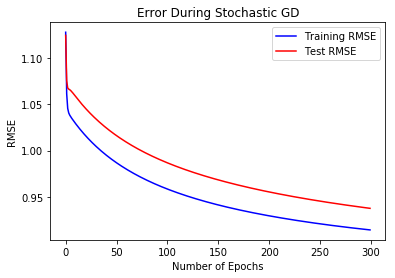

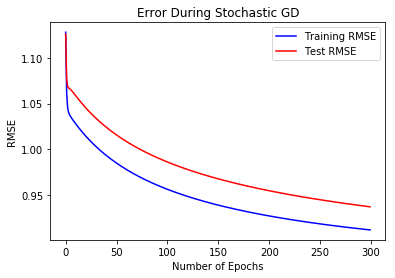

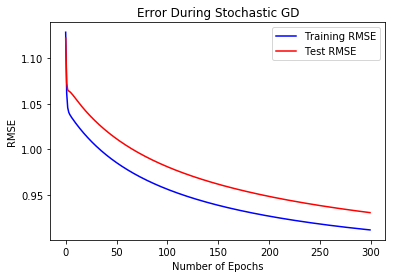

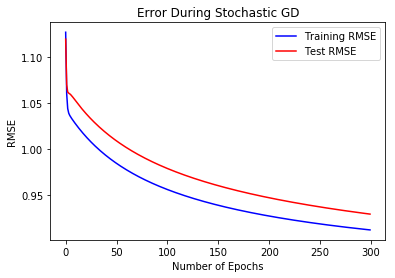

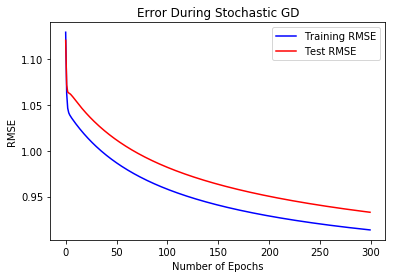

In [62]:
RMSE = 0
i = 1
for train, test in km.split(cv_ratings):
    trainset = cv_ratings.iloc[train, :]
    testset = cv_ratings.iloc[test, :]
    
    train_matrix = trainset.pivot(index='userId', columns='movieId', values='rating')
    #val_matrix = valset.pivot(index='userId', columns='movieId', values='rating')
    test_matrix = testset.pivot(index='userId', columns='movieId', values='rating')
    lfm_bias = LFM_bias(train_matrix, test_matrix)
    lfm_bias.initialize(k=10)
    lr = 0.0000001
    reg = 10
    trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 300)
    RMSE += test_err
    lfm_bias.trainplot()
RMSE = RMSE / 5
print('Test set RMSE for latent factor model with bias is ' + str(RMSE))

current training error: 1.128261855428386
current test error: 1.1277073641759994
Run took 12.66 seconds for epoch 0
current training error: 1.061217557765069
current test error: 1.079105941766165
Run took 12.66 seconds for epoch 1
current training error: 1.0454204284794446
current test error: 1.0714461205786419
Run took 12.53 seconds for epoch 2
current training error: 1.0405102958229664
current test error: 1.0702162730952893
Run took 12.47 seconds for epoch 3
current training error: 1.0380648130046124
current test error: 1.069511532211954
Run took 12.49 seconds for epoch 4
current training error: 1.0362321191931212
current test error: 1.0685377196445491
Run took 12.67 seconds for epoch 5
current training error: 1.034575828799983
current test error: 1.0673224473089111
Run took 12.46 seconds for epoch 6
current training error: 1.0329868208010948
current test error: 1.0659691004810021
Run took 12.51 seconds for epoch 7
current training error: 1.0314365515041344
current test error: 1.0645

current training error: 0.9718569617503078
current test error: 1.0043166696456165
Run took 12.53 seconds for epoch 70
current training error: 0.9712571164228075
current test error: 1.003691902359813
Run took 12.55 seconds for epoch 71
current training error: 0.9706642941460666
current test error: 1.003074011391015
Run took 12.61 seconds for epoch 72
current training error: 0.9700783676141154
current test error: 1.002462874824407
Run took 12.69 seconds for epoch 73
current training error: 0.9694992125801013
current test error: 1.0018583736246598
Run took 12.52 seconds for epoch 74
current training error: 0.9689267077659489
current test error: 1.0012603915520546
Run took 12.49 seconds for epoch 75
current training error: 0.9683607347751435
current test error: 1.0006688150814727
Run took 12.49 seconds for epoch 76
current training error: 0.967801178008504
current test error: 1.0000835333241345
Run took 12.45 seconds for epoch 77
current training error: 0.9672479245828389
current test erro

current training error: 0.9418718318769732
current test error: 0.9724175047825006
Run took 12.45 seconds for epoch 140
current training error: 0.9415671655957152
current test error: 0.9720846800558706
Run took 12.53 seconds for epoch 141
current training error: 0.9412649199752313
current test error: 0.9717542804436589
Run took 12.41 seconds for epoch 142
current training error: 0.940965064529255
current test error: 0.9714262760482383
Run took 12.49 seconds for epoch 143
current training error: 0.940667569292403
current test error: 0.9711006374751863
Run took 12.46 seconds for epoch 144
current training error: 0.9403724048092439
current test error: 0.9707773358228794
Run took 12.50 seconds for epoch 145
current training error: 0.9400795421236358
current test error: 0.9704563426723444
Run took 12.47 seconds for epoch 146
current training error: 0.9397889527683366
current test error: 0.9701376300773626
Run took 12.45 seconds for epoch 147
current training error: 0.9395006087548758
current

current training error: 0.9250960542711452
current test error: 0.9537021429565293
Run took 12.43 seconds for epoch 210
current training error: 0.9249082275419958
current test error: 0.9534872618413751
Run took 12.53 seconds for epoch 211
current training error: 0.9247215282935587
current test error: 0.9532735297077511
Run took 12.50 seconds for epoch 212
current training error: 0.9245359460959294
current test error: 0.9530609361870939
Run took 12.72 seconds for epoch 213
current training error: 0.9243514706620205
current test error: 0.952849471051456
Run took 12.58 seconds for epoch 214
current training error: 0.9241680918452757
current test error: 0.9526391242112886
Run took 12.61 seconds for epoch 215
current training error: 0.9239857996374298
current test error: 0.9524298857132661
Run took 12.52 seconds for epoch 216
current training error: 0.9238045841663146
current test error: 0.9522217457381533
Run took 12.45 seconds for epoch 217
current training error: 0.9236244356937032
curren

current training error: 0.9143368281624907
current test error: 0.9411284881577977
Run took 12.48 seconds for epoch 279
current training error: 0.9142082384060661
current test error: 0.9409743978014966
Run took 12.45 seconds for epoch 280
current training error: 0.9140803013898093
current test error: 0.9408209830826926
Run took 12.46 seconds for epoch 281
current training error: 0.9139530128593797
current test error: 0.9406682397476911
Run took 12.53 seconds for epoch 282
current training error: 0.9138263686133831
current test error: 0.9405161635955791
Run took 12.47 seconds for epoch 283
current training error: 0.913700364502698
current test error: 0.940364750477563
Run took 12.50 seconds for epoch 284
current training error: 0.913574996429822
current test error: 0.9402139962963181
Run took 12.55 seconds for epoch 285
current training error: 0.9134502603482215
current test error: 0.9400638970053515
Run took 12.48 seconds for epoch 286
current training error: 0.9133261522616942
current 

current training error: 0.9068119219393858
current test error: 0.9318977202004185
Run took 12.51 seconds for epoch 348
current training error: 0.9067206874350051
current test error: 0.9317825629875172
Run took 12.55 seconds for epoch 349
current training error: 0.9066299087890446
current test error: 0.9316678844655218
Run took 12.52 seconds for epoch 350
current training error: 0.9065395842624139
current test error: 0.9315536828949318
Run took 12.50 seconds for epoch 351
current training error: 0.9064497121404995
current test error: 0.9314399565607612
Run took 12.53 seconds for epoch 352
current training error: 0.906360290732936
current test error: 0.9313267037723032
Run took 12.53 seconds for epoch 353
current training error: 0.9062713183733727
current test error: 0.9312139228629017
Run took 12.46 seconds for epoch 354
current training error: 0.9061827934192485
current test error: 0.9311016121897252
Run took 12.49 seconds for epoch 355
current training error: 0.9060947142515692
curren

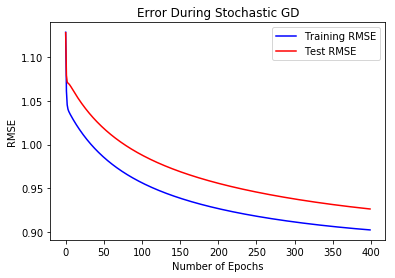

In [15]:
lfm_bias = LFM_bias(train_matrix, test_matrix)
lfm_bias.initialize(k=10)
lr = 0.0000001
reg = 10
trg_err, test_err = lfm_bias.train(lr, lr, reg, reg, 400)
lfm_bias.trainplot()

In [185]:
lfm_bias.pred_forall()

In [186]:
lfm_bias_testset = testset

lfm_bias_testset['pred'] = lfm_bias_testset.apply(lambda x: lfm_bias.pred.loc[x["userId"], x["movieId"]], axis=1)

/Users/wangjingci/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [190]:
def recall_bias_lfm():
    #like = pred_rating_lfm[[movieid]][pred_rating_lfm[movieid] == 1].index.tolist()
    #real = true_rating_lfm[[movieid]][true_rating_lfm[movieid] == 1].index.tolist()
    like = lfm_bias_testset[lfm_bias_testset['pred'] >= 3].index.tolist()
    real = lfm_bias_testset[lfm_bias_testset['rating'] >= 3].index.tolist()
    correct = len(set(like).intersection(set(real)))   
    return correct / (len(real) + 0.0001)
def precision_bias_lfm():
    #like = pred_rating_lfm[[movieid]][pred_rating_lfm[movieid] == 1].index.tolist()
    #real = true_rating_lfm[[movieid]][true_rating_lfm[movieid] == 1].index.tolist()
    like = lfm_bias_testset[lfm_bias_testset['pred'] >= 3].index.tolist()
    real = lfm_bias_testset[lfm_bias_testset['rating'] > 3].index.tolist()
    correct = len(set(like).intersection(set(real))) 
    return correct / (len(like) + 0.0001)

In [191]:
recall = recall_bias_lfm()
precision = precision_bias_lfm()
#for id in lfm_testset['movieId']:
#    recall += recall_lfm(id)
#    precision += precision_lfm(id)
    #print(precision_lfm(id))

#recall = recall / pred_rating_lfm.shape[1]
#precision = precision / pred_rating_lfm.shape[1]
print('Recall rate for latent factor model is: ' + str(recall))
print('Precision rate for latent factor model is: ' + str(precision))

Recall rate for latent factor model is: 0.7557758007649273
Precision rate for latent factor model is: 0.7354408634012733


In [177]:
from surprise import BaselineOnly
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate


In [178]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)

Using ALS


In [179]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(sub_ratings[['userId', 'movieId', 'rating']], reader)
train, test = train_test_split(data, test_size=0.2)

In [180]:
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.8100  0.8201  0.8153  0.8156  0.8232  0.8164  0.8155  0.8169  0.8230  0.8139  0.8170  0.0039  
MAE (testset)     0.6214  0.6294  0.6261  0.6255  0.6306  0.6274  0.6243  0.6268  0.6311  0.6257  0.6268  0.0028  
Fit time          1.07    1.32    1.33    1.33    1.36    1.33    1.38    1.34    1.35    1.34    1.32    0.08    
Test time         0.75    0.71    0.98    0.71    0.69    0.69    0.71    0.96    0.70    0.69    0.76    0.11    


{'test_rmse': array([0.81000817, 0.82006601, 0.81527658, 0.81564574, 0.82316009,
        0.81644443, 0.8155042 , 0.81691303, 0.82304361, 0.81385518]),
 'test_mae': array([0.62140927, 0.62944956, 0.62612083, 0.62554716, 0.63056097,
        0.62735321, 0.62431983, 0.62681023, 0.63113155, 0.62565406]),
 'fit_time': (1.0681540966033936,
  1.3247301578521729,
  1.3326389789581299,
  1.3333251476287842,
  1.3551249504089355,
  1.333571195602417,
  1.3768880367279053,
  1.3397140502929688,
  1.3530879020690918,
  1.3373019695281982),
 'test_time': (0.7541220188140869,
  0.7075998783111572,
  0.9825489521026611,
  0.7081608772277832,
  0.6936378479003906,
  0.6930909156799316,
  0.7133948802947998,
  0.9559059143066406,
  0.7025949954986572,
  0.691756010055542)}

In [182]:
rmse = np.array([0.81000817, 0.82006601, 0.81527658, 0.81564574, 0.82316009,
        0.81644443, 0.8155042 , 0.81691303, 0.82304361, 0.81385518])
print('ALS RMSE after 10-fold CV: ' + str(rmse.mean()))

ALS RMSE after 10-fold CV: 0.8169917040000001


In [478]:
algo.fit(train)

Estimating biases using als...


In [479]:
test = algo.test(test)

In [480]:
test = pd.DataFrame(test)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions', 'details']
test.head()

,userId,movieId,actual,cf_predictions,details
0,66617,2918,3.0,2.994105,{'was_impossible': False}
1,68558,2396,3.5,3.393535,{'was_impossible': False}
2,79366,2006,3.5,3.460250,{'was_impossible': False}
3,137130,1580,4.5,3.814852,{'was_impossible': False}
4,40008,5995,4.5,4.104908,{'was_impossible': False}


In [481]:
rmse(test['actual'], test['cf_predictions'])

0.8153514665857242